# Trips

The daily number of trips are computed based on precomputed stays data.



Trips metrics that are not specific to parish (municipality) are computed by the `trips.py` script.

They are plotted here to check whether they are sensible.

Parish specific metrics are further below.


## User trips 
The number of daily trips for each subscriber was computed as their daily number of stay points minus 1, since a new stay point is recorded when a subscriber moves beyond a 200m radius.

## Users making trips
The number of users making trips each day is also computed as the number of unique subscribers with more than 0 trips.

## Total trips
Total trips per day is the sum over all users' trips that day.

## Mean and median trips
Computed as the average daily trips per user.


In [2]:
%config IPCompleter.greedy=True # jupyter autocomplete

from datetime import datetime, timedelta
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd


IMSI = 'imsi'
MCC ='mcc'
DATE = 'date'

TOTAL_TRIPS = 'total trips'
USERS_MAKING_TRIPS = 'users making trips'
# per user metrics
TRIPS_MEAN = 'mean trips'
TRIPS_MEDIAN = 'median trips'

date_fmt = '%Y-%m-%d'

PRIVATE_DATA_FPATH = '../../data/private'
METRICS_FPATH = '../../outputs/metrics'


In [7]:
trips_df = pd.read_csv(METRICS_FPATH+'/2020/trips.csv').set_index(DATE)
trips_df.index = pd.to_datetime(trips_df.index)
trips_df.head()

users making trips  total trips  mean trips  median trips
date                                                                 
2020-01-01               73063       531963    5.789632           3.0
2020-01-02               92473       696547    6.284994           4.0
2020-01-03               89661       691506    6.485220           4.0
2020-01-04               82706       595940    5.914509           4.0
2020-01-05               73210       523706    5.805667           4.0

Plot all of these metrics over time

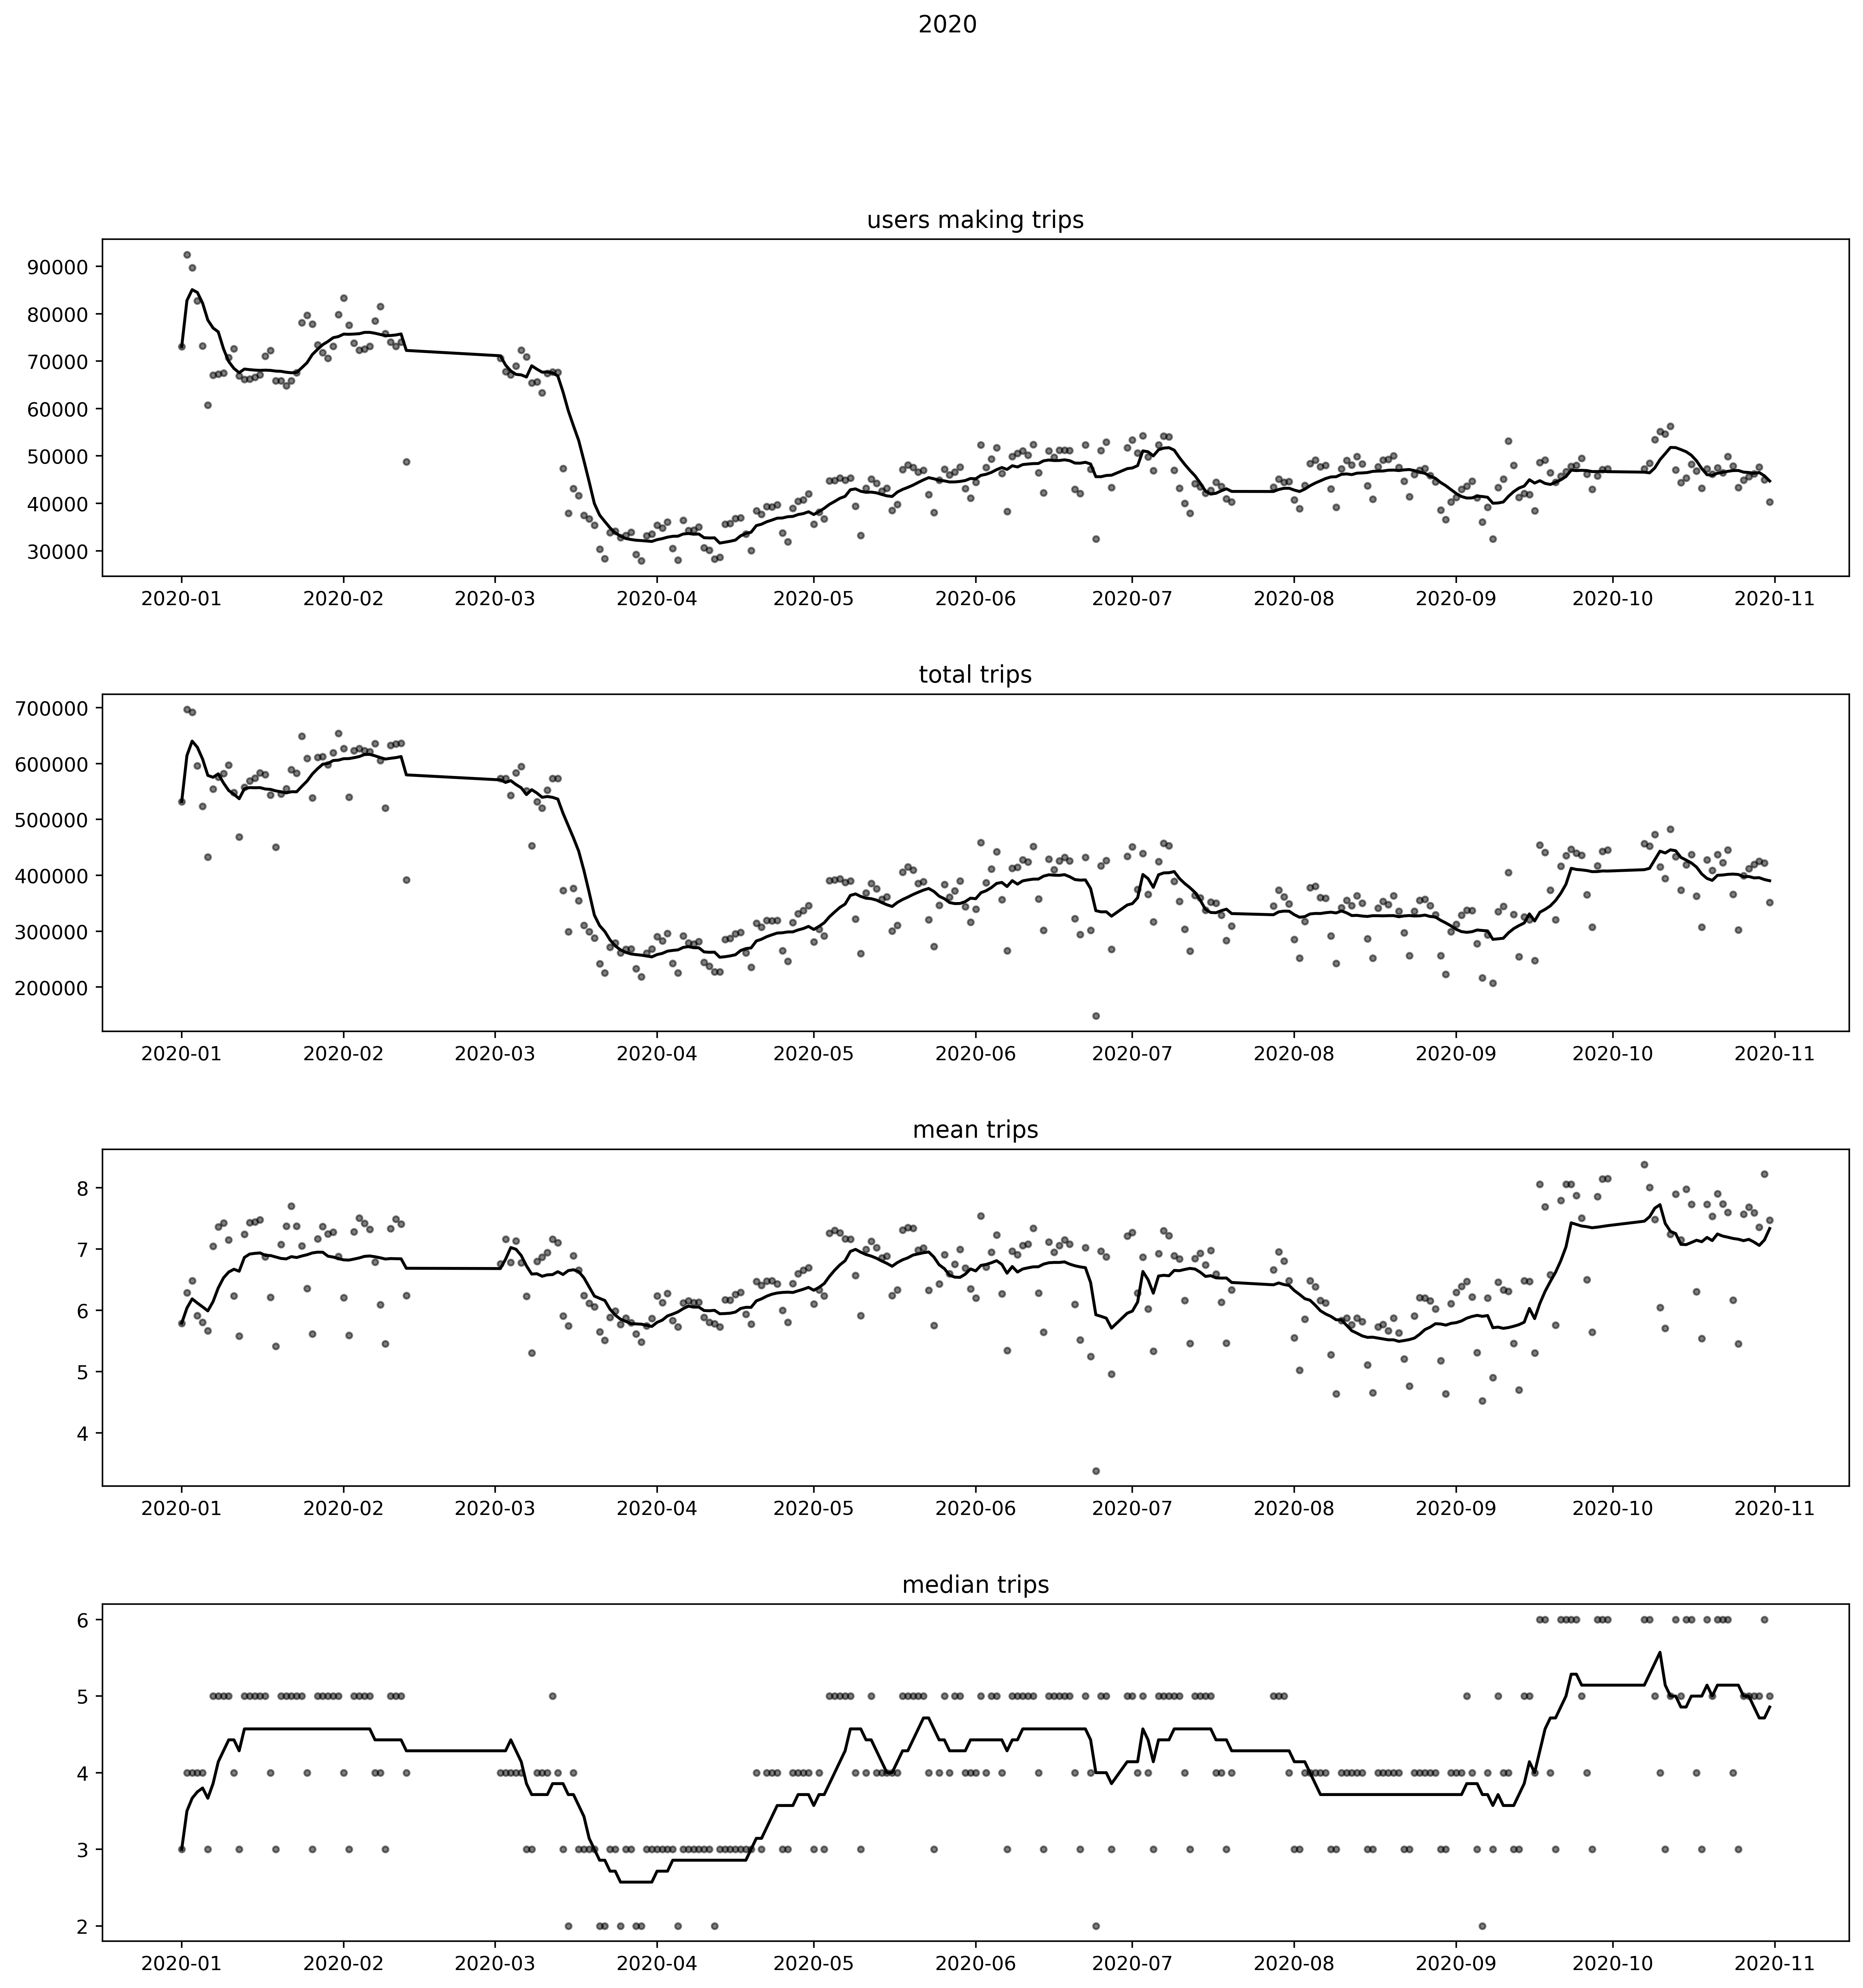

In [21]:
metrics = trips_df.columns

rows = len(metrics)
fig, ax= plt.subplots(rows, figsize=(16, rows*4), dpi=200)
color = 'black'
plt.subplots_adjust(hspace=0.35)
fig.suptitle('2020')
for i, m in enumerate(metrics):
    ax[i].plot(trips_df.index, trips_df[m], '.', c=color, alpha=0.5)
    ax[i].plot(trips_df.index, trips_df.dropna()[m].rolling(7, min_periods=1).mean(), '-', c=color)
    ax[i].set_title(m)
    

Note that:

The total number of trips is influenced by the total number of users making trips. There were fewer people in the country after the lockdown and border retrictions were put in place. 

The average number of trips per user dipped at the start of the lockdown in March and then rose again in May.

# Trips within and between parishes



In [22]:
parishes = ['Andorra la Vella', 'Canillo', 'Encamp', 'Escaldes-Engordany',
            'La Massana', 'Ordino', 'Sant Julià de Lòria']

Boiler plate

In [14]:
def get_stays_filepath(day, month, year):
    return '{}/stays/{}_{}/stays_{}_{}_{}.csv'.format(PRIVATE_DATA_FPATH, year, month, year, month, day)

def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + timedelta(n)

In [15]:
start_date_2019 = '2019-03-02'
end_date_2019 = '2019-06-01'

start_date_2020 = '2020-03-02'
end_date_2020 = '2020-06-01'

dates_2019 = [d for d in daterange(datetime.datetime.strptime(start_date_2019, date_fmt), 
                                   datetime.datetime.strptime(end_date_2019, date_fmt))]
dates_2020 = [d for d in daterange(datetime.datetime.strptime(start_date_2020, date_fmt), 
                                   datetime.datetime.strptime(end_date_2020, date_fmt))]
# dates_2019

### Analyze trips  per user within each parish.
And identify where the "superspreaders" might be.


Make a  table:

`
date, parish, users, mean trips, median trips, 99th percentile trips
`

Where 
- users is the number  of  total users with stays in the  parish on the  given day
- trips for each user within a parish are counted as the number of  stays that the user has within that parish, minus 1.
- users within multiple stays within multiple parishes on a given day will have trips  counted  in each parish

In [36]:
STAY_START  = 's'
PARISH_NAME = 'parish'
USER_COUNT = 'users'
TRIPS_COUNT = 'trips'
TRIPS_MEAN = 'mean trips'
TRIPS_MEDIAN = 'median trips'
TRIPS_99_PCT  = '99th percentile trips'

def get_trips_with_parish_df(dates):
    trips_within_parish_records = []
    for i, d in enumerate(dates):
        stays_filepath = get_stays_filepath(d.day, d.month, d.year)
        date_str =  d.strftime("%Y-%m-%d")
        print('%s/%s %s' %  (i, len(dates), date_str))
        if not pathlib.Path(stays_filepath).is_file():
            print('skipping %s -- file not found: %s' % (date_str, stays_filepath))
            continue
        df = pd.read_csv(stays_filepath)
        for parish in parishes:
            parish_df = df[df[PARISH_NAME]==parish]
            trips = (parish_df[IMSI].value_counts() - 1)
            trips_within_parish_records +=  [{
                DATE: d,
                PARISH_NAME: parish,
                USER_COUNT: parish_df[IMSI].nunique(),
                TRIPS_COUNT: trips.sum(),
                TRIPS_MEAN: trips.mean(),
                TRIPS_MEDIAN: trips.median(),
                TRIPS_99_PCT: np.percentile(trips, 99)
            }]
    trips_within_parish_df = pd.DataFrame.from_records(trips_within_parish_records)
    return trips_within_parish_df
        

In [37]:
trips_within_parish_2019_df = get_trips_with_parish_df(dates_2019)

0/92 2019-03-02
1/92 2019-03-03
2/92 2019-03-04
3/92 2019-03-05
4/92 2019-03-06
5/92 2019-03-07
6/92 2019-03-08
7/92 2019-03-09
8/92 2019-03-10
9/92 2019-03-11
10/92 2019-03-12
11/92 2019-03-13
12/92 2019-03-14
13/92 2019-03-15
14/92 2019-03-16
15/92 2019-03-17
16/92 2019-03-18
17/92 2019-03-19
18/92 2019-03-20
19/92 2019-03-21
20/92 2019-03-22
21/92 2019-03-23
22/92 2019-03-24
23/92 2019-03-25
24/92 2019-03-26
25/92 2019-03-27
26/92 2019-03-28
27/92 2019-03-29
28/92 2019-03-30
29/92 2019-03-31
30/92 2019-04-01
31/92 2019-04-02
32/92 2019-04-03
33/92 2019-04-04
34/92 2019-04-05
35/92 2019-04-06
36/92 2019-04-07
37/92 2019-04-08
38/92 2019-04-09
39/92 2019-04-10
40/92 2019-04-11
41/92 2019-04-12
42/92 2019-04-13
43/92 2019-04-14
44/92 2019-04-15
45/92 2019-04-16
46/92 2019-04-17
47/92 2019-04-18
48/92 2019-04-19
49/92 2019-04-20
50/92 2019-04-21
51/92 2019-04-22
52/92 2019-04-23
53/92 2019-04-24
54/92 2019-04-25
55/92 2019-04-26
56/92 2019-04-27
57/92 2019-04-28
58/92 2019-04-29
59/92 2

In [21]:
trips_within_parish_2020_df = get_trips_with_parish_df(dates_2020)

0/92 2020-03-02
1/92 2020-03-03
2/92 2020-03-04
3/92 2020-03-05
4/92 2020-03-06
5/92 2020-03-07
6/92 2020-03-08
7/92 2020-03-09
8/92 2020-03-10
9/92 2020-03-11
10/92 2020-03-12
11/92 2020-03-13
12/92 2020-03-14
13/92 2020-03-15
14/92 2020-03-16
15/92 2020-03-17
16/92 2020-03-18
17/92 2020-03-19
18/92 2020-03-20
19/92 2020-03-21
20/92 2020-03-22
21/92 2020-03-23
22/92 2020-03-24
23/92 2020-03-25
24/92 2020-03-26
25/92 2020-03-27
26/92 2020-03-28
27/92 2020-03-29
28/92 2020-03-30
29/92 2020-03-31
30/92 2020-04-01
31/92 2020-04-02
32/92 2020-04-03
33/92 2020-04-04
34/92 2020-04-05
35/92 2020-04-06
36/92 2020-04-07
37/92 2020-04-08
38/92 2020-04-09
39/92 2020-04-10
40/92 2020-04-11
41/92 2020-04-12
42/92 2020-04-13
43/92 2020-04-14
44/92 2020-04-15
45/92 2020-04-16
46/92 2020-04-17
47/92 2020-04-18
48/92 2020-04-19
49/92 2020-04-20
50/92 2020-04-21
51/92 2020-04-22
52/92 2020-04-23
53/92 2020-04-24
54/92 2020-04-25
55/92 2020-04-26
56/92 2020-04-27
57/92 2020-04-28
58/92 2020-04-29
59/92 2

In [22]:
trips_within_parish_2020_df.head(10)

99th percentile trips       date  mean trips  median trips  \
0                   23.0 2020-03-02    3.469323           2.0   
1                   31.0 2020-03-02    4.692673           2.0   
2                   27.0 2020-03-02    4.162181           2.0   
3                   19.0 2020-03-02    2.321207           1.0   
4                   28.0 2020-03-02    4.324182           2.0   
5                   23.0 2020-03-02    3.517645           2.0   
6                   19.0 2020-03-02    2.442029           1.0   
7                   24.0 2020-03-03    3.663375           2.0   
8                   32.0 2020-03-03    5.170339           2.0   
9                   28.0 2020-03-03    4.102046           2.0   

                parish   trips  users  
0     Andorra la Vella  159686  46028  
1              Canillo  104778  22328  
2               Encamp   65571  15754  
3   Escaldes-Engordany   57169  24629  
4           La Massana   68828  15917  
5               Ordino   23125   6574  
6  Sant Julià de Lòria   33700  13800  
7     Andorra la Vella  160998  43948  
8              Canillo  103717  20060  
9               Encamp   62749  15297

In [28]:
import matplotlib as mpl
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker

cmap = plt.get_cmap("tab10")

COLOR = 'gray'
def set_colors(color=COLOR):
    mpl.rcParams['text.color'] = color
    mpl.rcParams['axes.labelcolor'] = color
    mpl.rcParams['xtick.color'] = color
    mpl.rcParams['ytick.color'] = color
    # transparent background
    plt.rcParams.update({
        "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # red   with alpha = 30%
        "axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  # green with alpha = 50%
        "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),  # blue  with alpha = 20%
    })

In [111]:
def make_trips_by_parish_plot(df, year, title, 
                              ylabel='trips', 
                              ax=None, legend=True):
    if not ax:
        figure, ax = plt.subplots(figsize=(20, 6))
  
    # reformat date
    df['day'] = df[DATE].apply(lambda d: d.strftime('%b/%d'))
    for i, parish in enumerate(parishes):
        p_df = df[df[PARISH_NAME]==parish]
        index = p_df['day']
        ax.plot(index,
                p_df[TRIPS_COUNT],
                label='%s'%parish,
                alpha=0.9,
                color=cmap(i),
                linestyle='-',
        )
        ax.set_ylabel('trips')
        ax.set_title(('%s: '+title) % year)
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.margins(0)
        ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
        ax.legend(facecolor=COLOR, framealpha=0)
        if not legend:
            ax.get_legend().remove()
        ax.tick_params(axis='x', labelrotation=90)


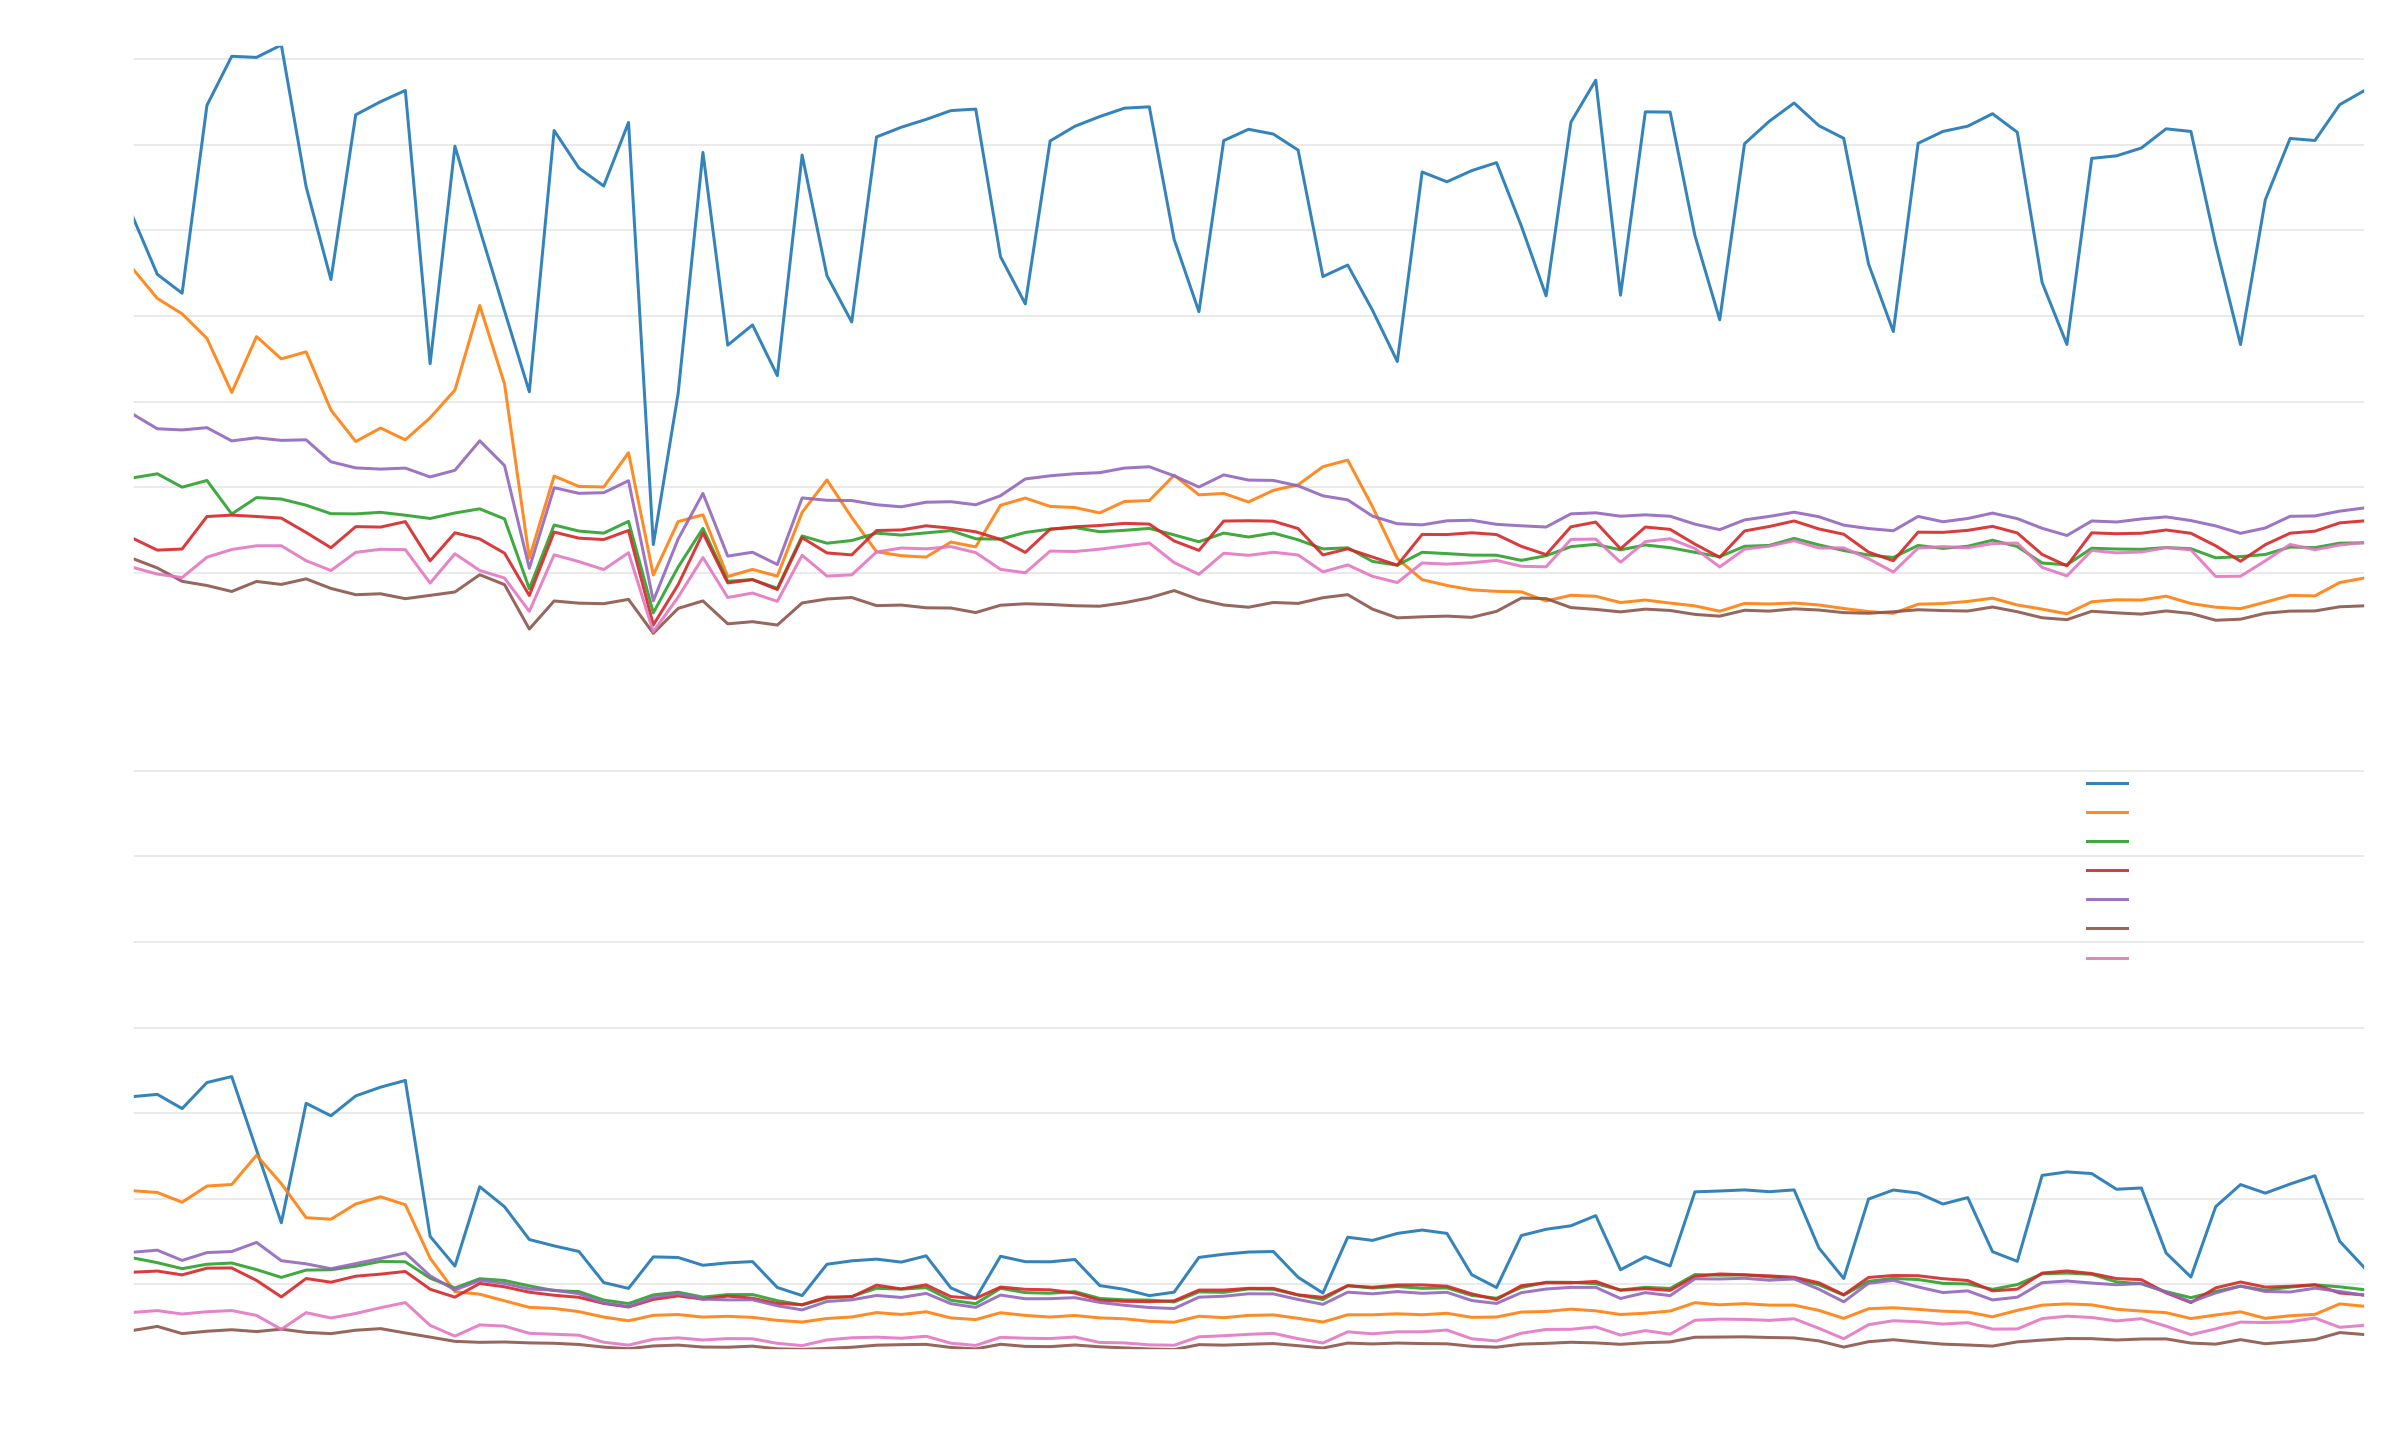

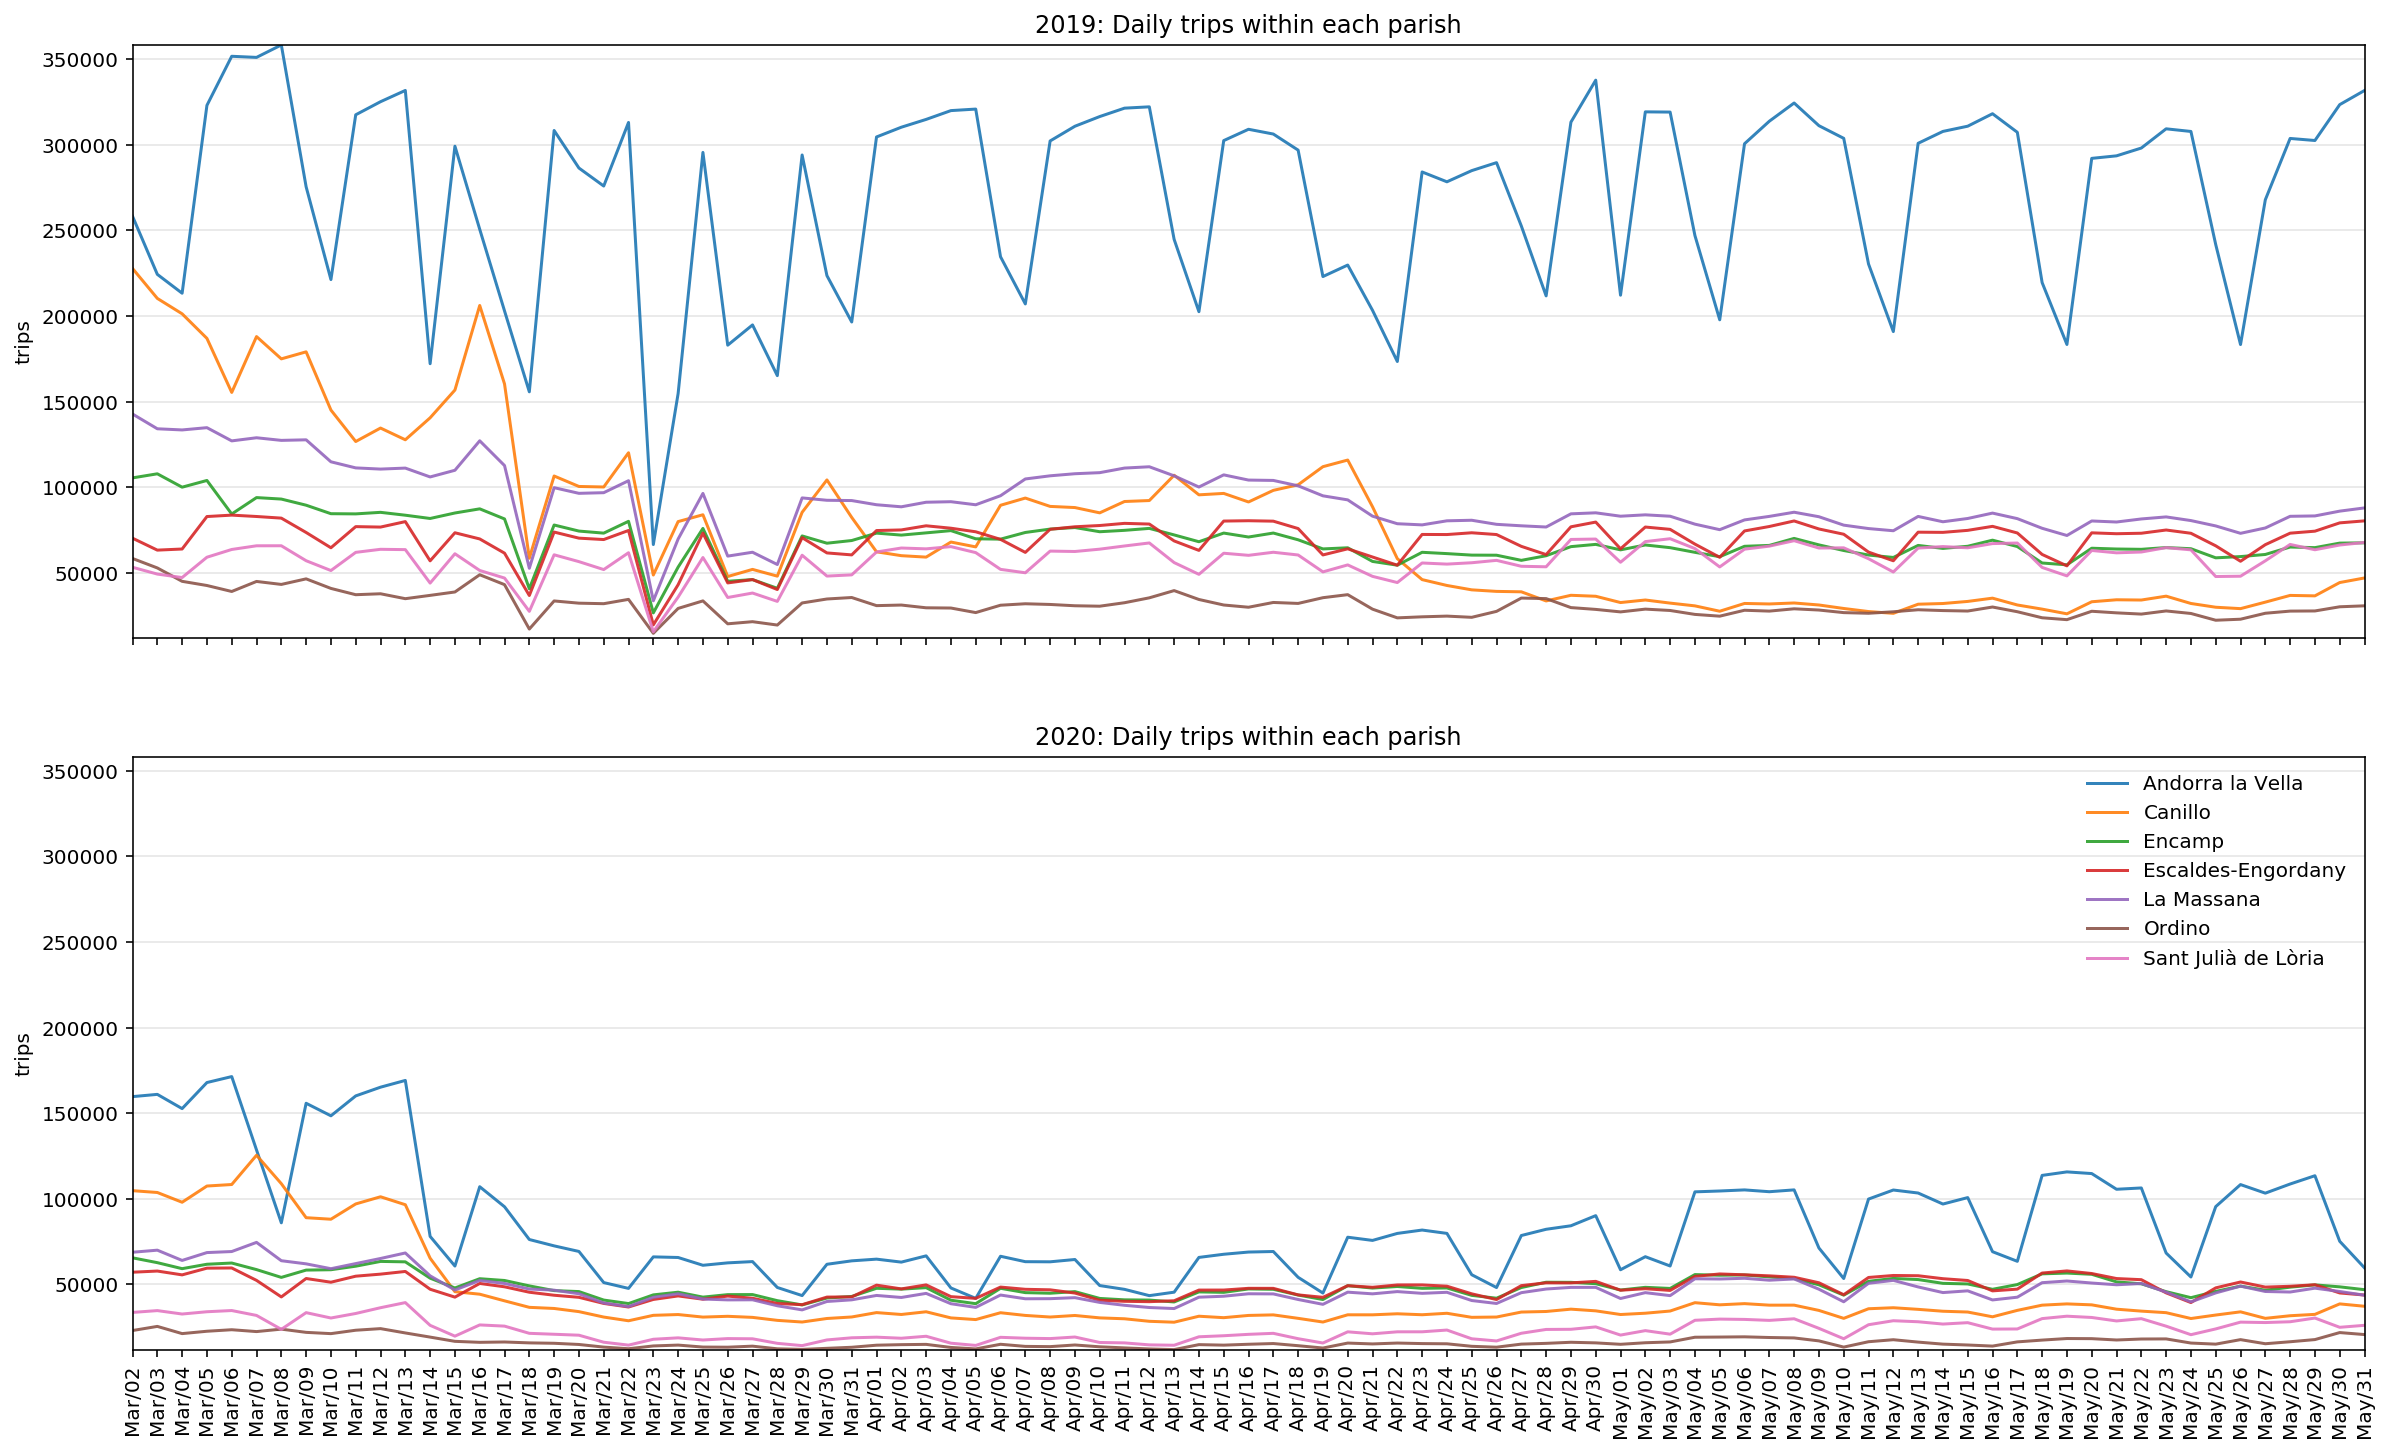

In [138]:
COLOR='white'
set_colors(COLOR)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)

title='Daily trips within each parish'
make_trips_by_parish_plot(trips_within_parish_2019_df, 
                    2019, title, ylabel='trips', ax=ax1,legend=False)
make_trips_by_parish_plot(trips_within_parish_2020_df, 
                    2020, title, ylabel='trips', ax=ax2)
plt.setp(ax1.spines.values(), color=COLOR)
plt.setp(ax2.spines.values(), color=COLOR)
plt.show()


COLOR='black'
set_colors(COLOR)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)
make_trips_by_parish_plot(trips_within_parish_2019_df, 
                    2019, title, ylabel='trips', ax=ax1,legend=False)
make_trips_by_parish_plot(trips_within_parish_2020_df, 
                    2020, title, ylabel='trips', ax=ax2)
plt.show()

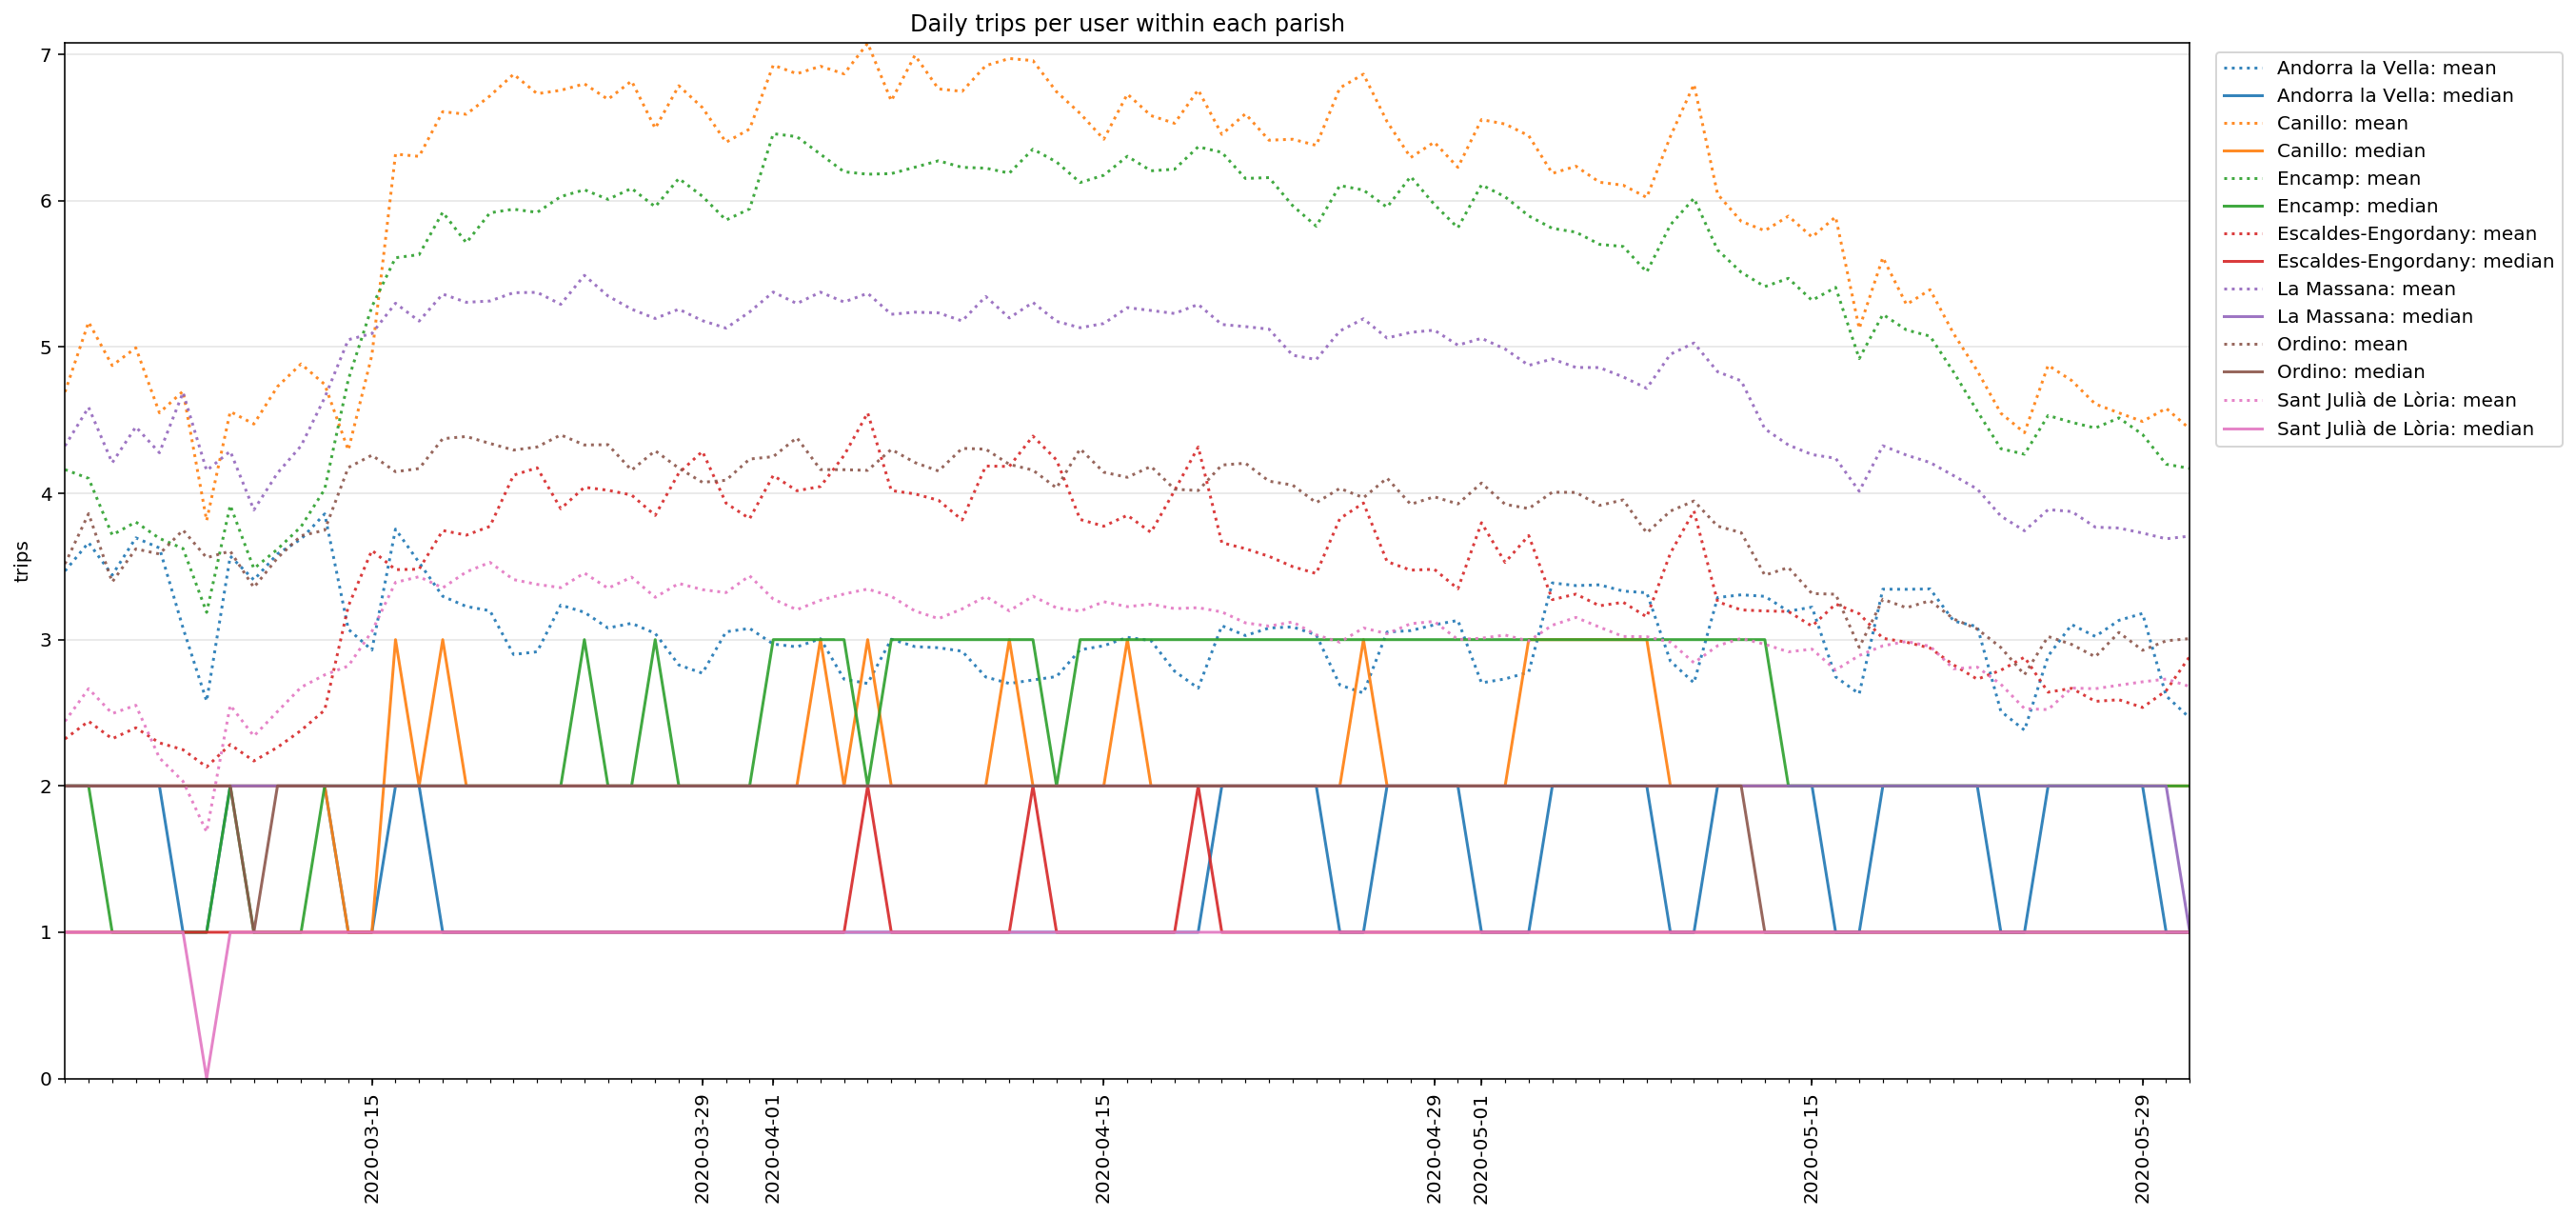

In [139]:
figure, ax = plt.subplots(figsize=(20, 10))

for i, parish in enumerate(parishes):
    p_df = trips_within_parish_2020_df[trips_within_parish_2020_df[PARISH_NAME]==parish]
    index = p_df[DATE]
    ax.plot(index,
            p_df[TRIPS_MEAN],
            label='%s: mean'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle=':',
    )
    ax.plot(index,
            p_df[TRIPS_MEDIAN],
            label='%s: median'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle='-',
    )
    ax.set_ylabel('trips')
    ax.set_title('Daily trips per user within each parish')
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend(bbox_to_anchor=(1.18, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

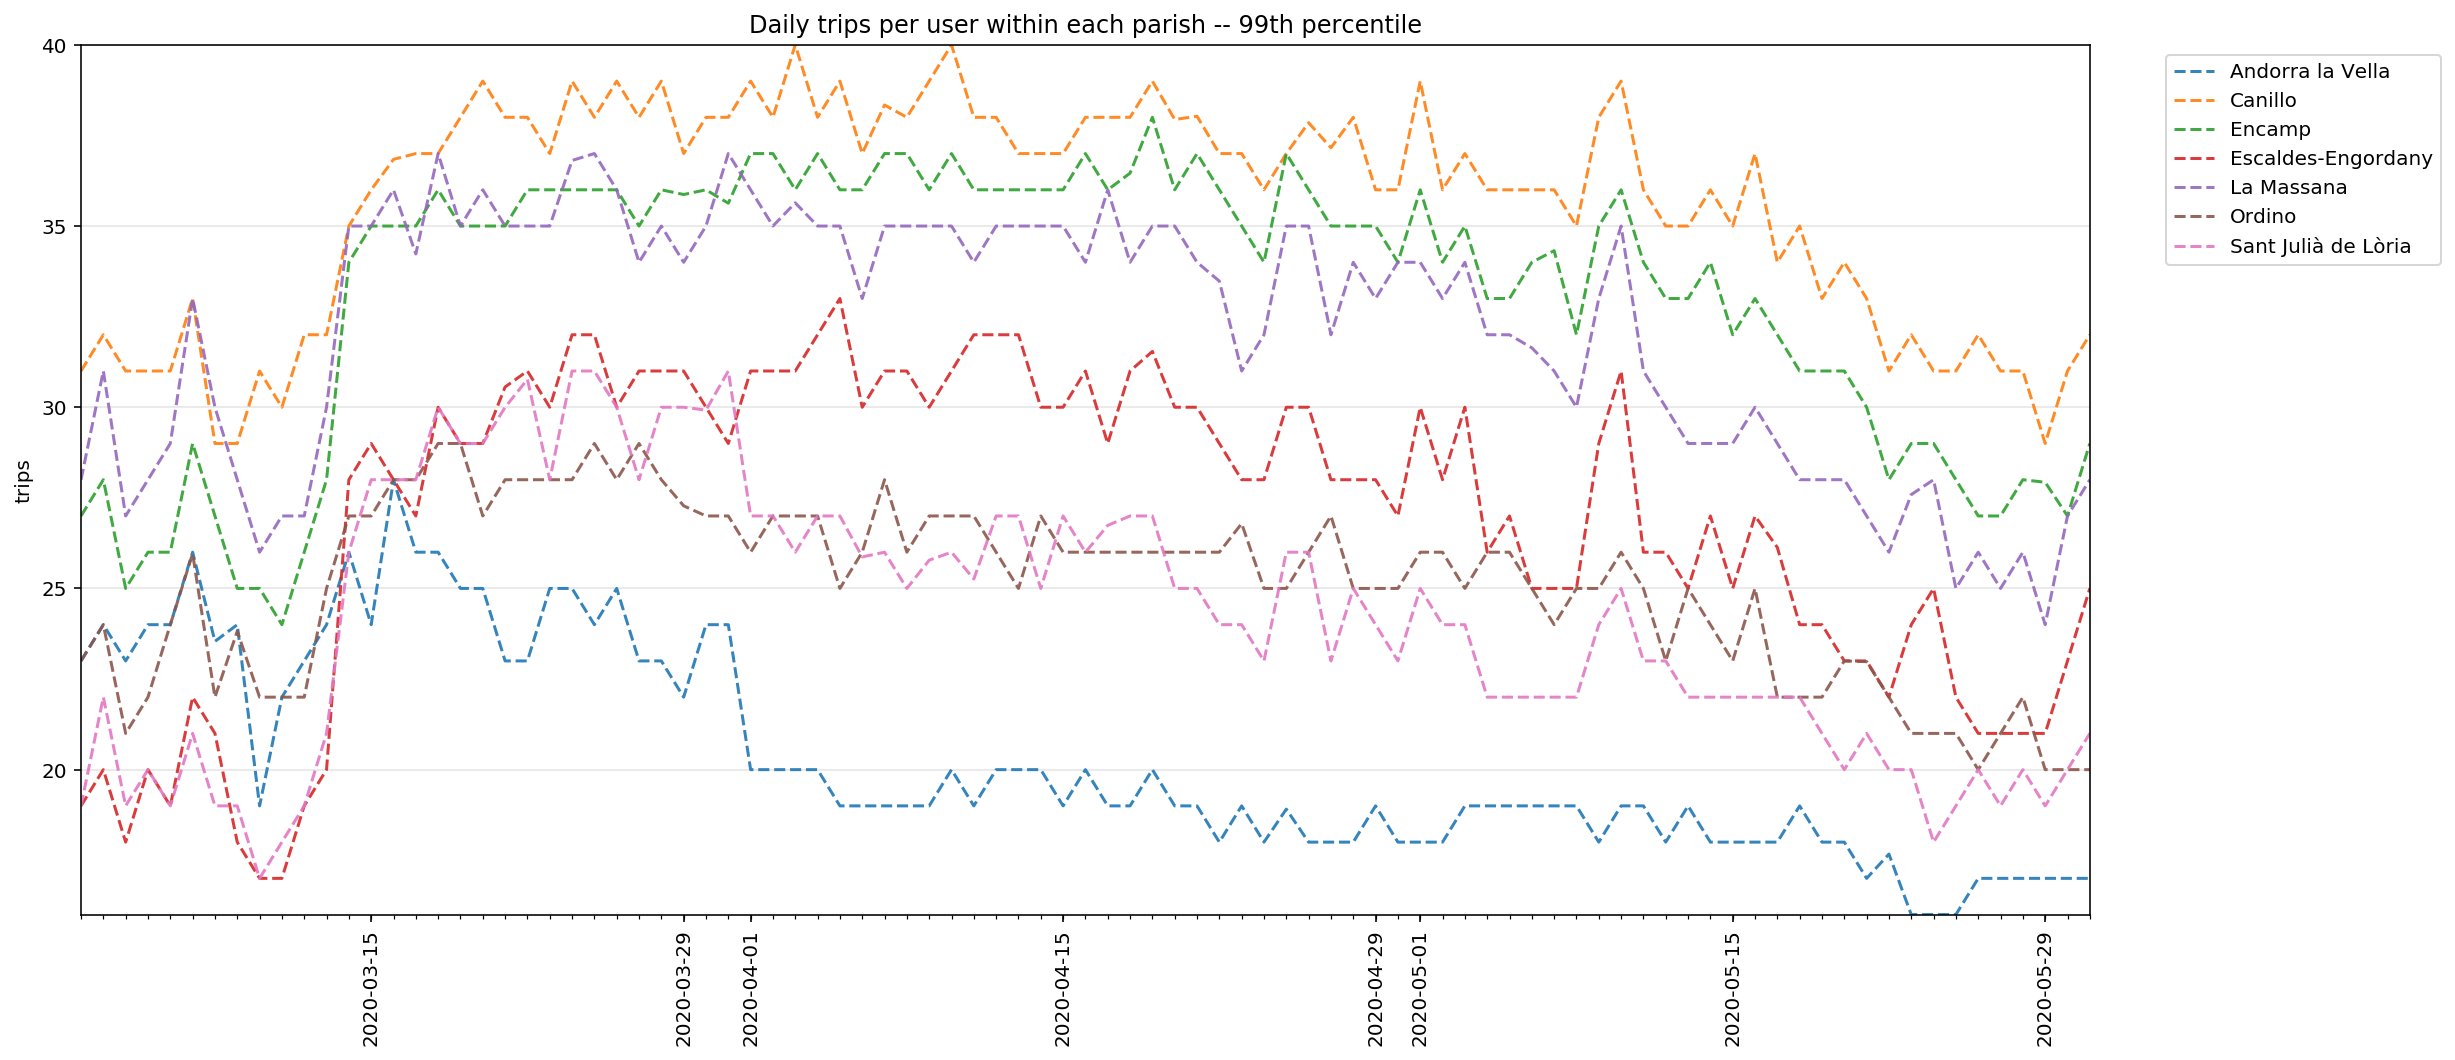

In [56]:
figure, ax = plt.subplots(figsize=(18, 8))

for i, parish in enumerate(parishes):
    p_df = trips_within_parish_2020_df[trips_within_parish_2020_df[PARISH_NAME]==parish]
    index = p_df[DATE]
    ax.plot(index,
            p_df[TRIPS_99_PCT],
            label='%s'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle='--',
    ) 
    ax.set_ylabel('trips')
    ax.set_title('Daily trips per user within each parish -- 99th percentile')
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend(bbox_to_anchor=(1.18, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

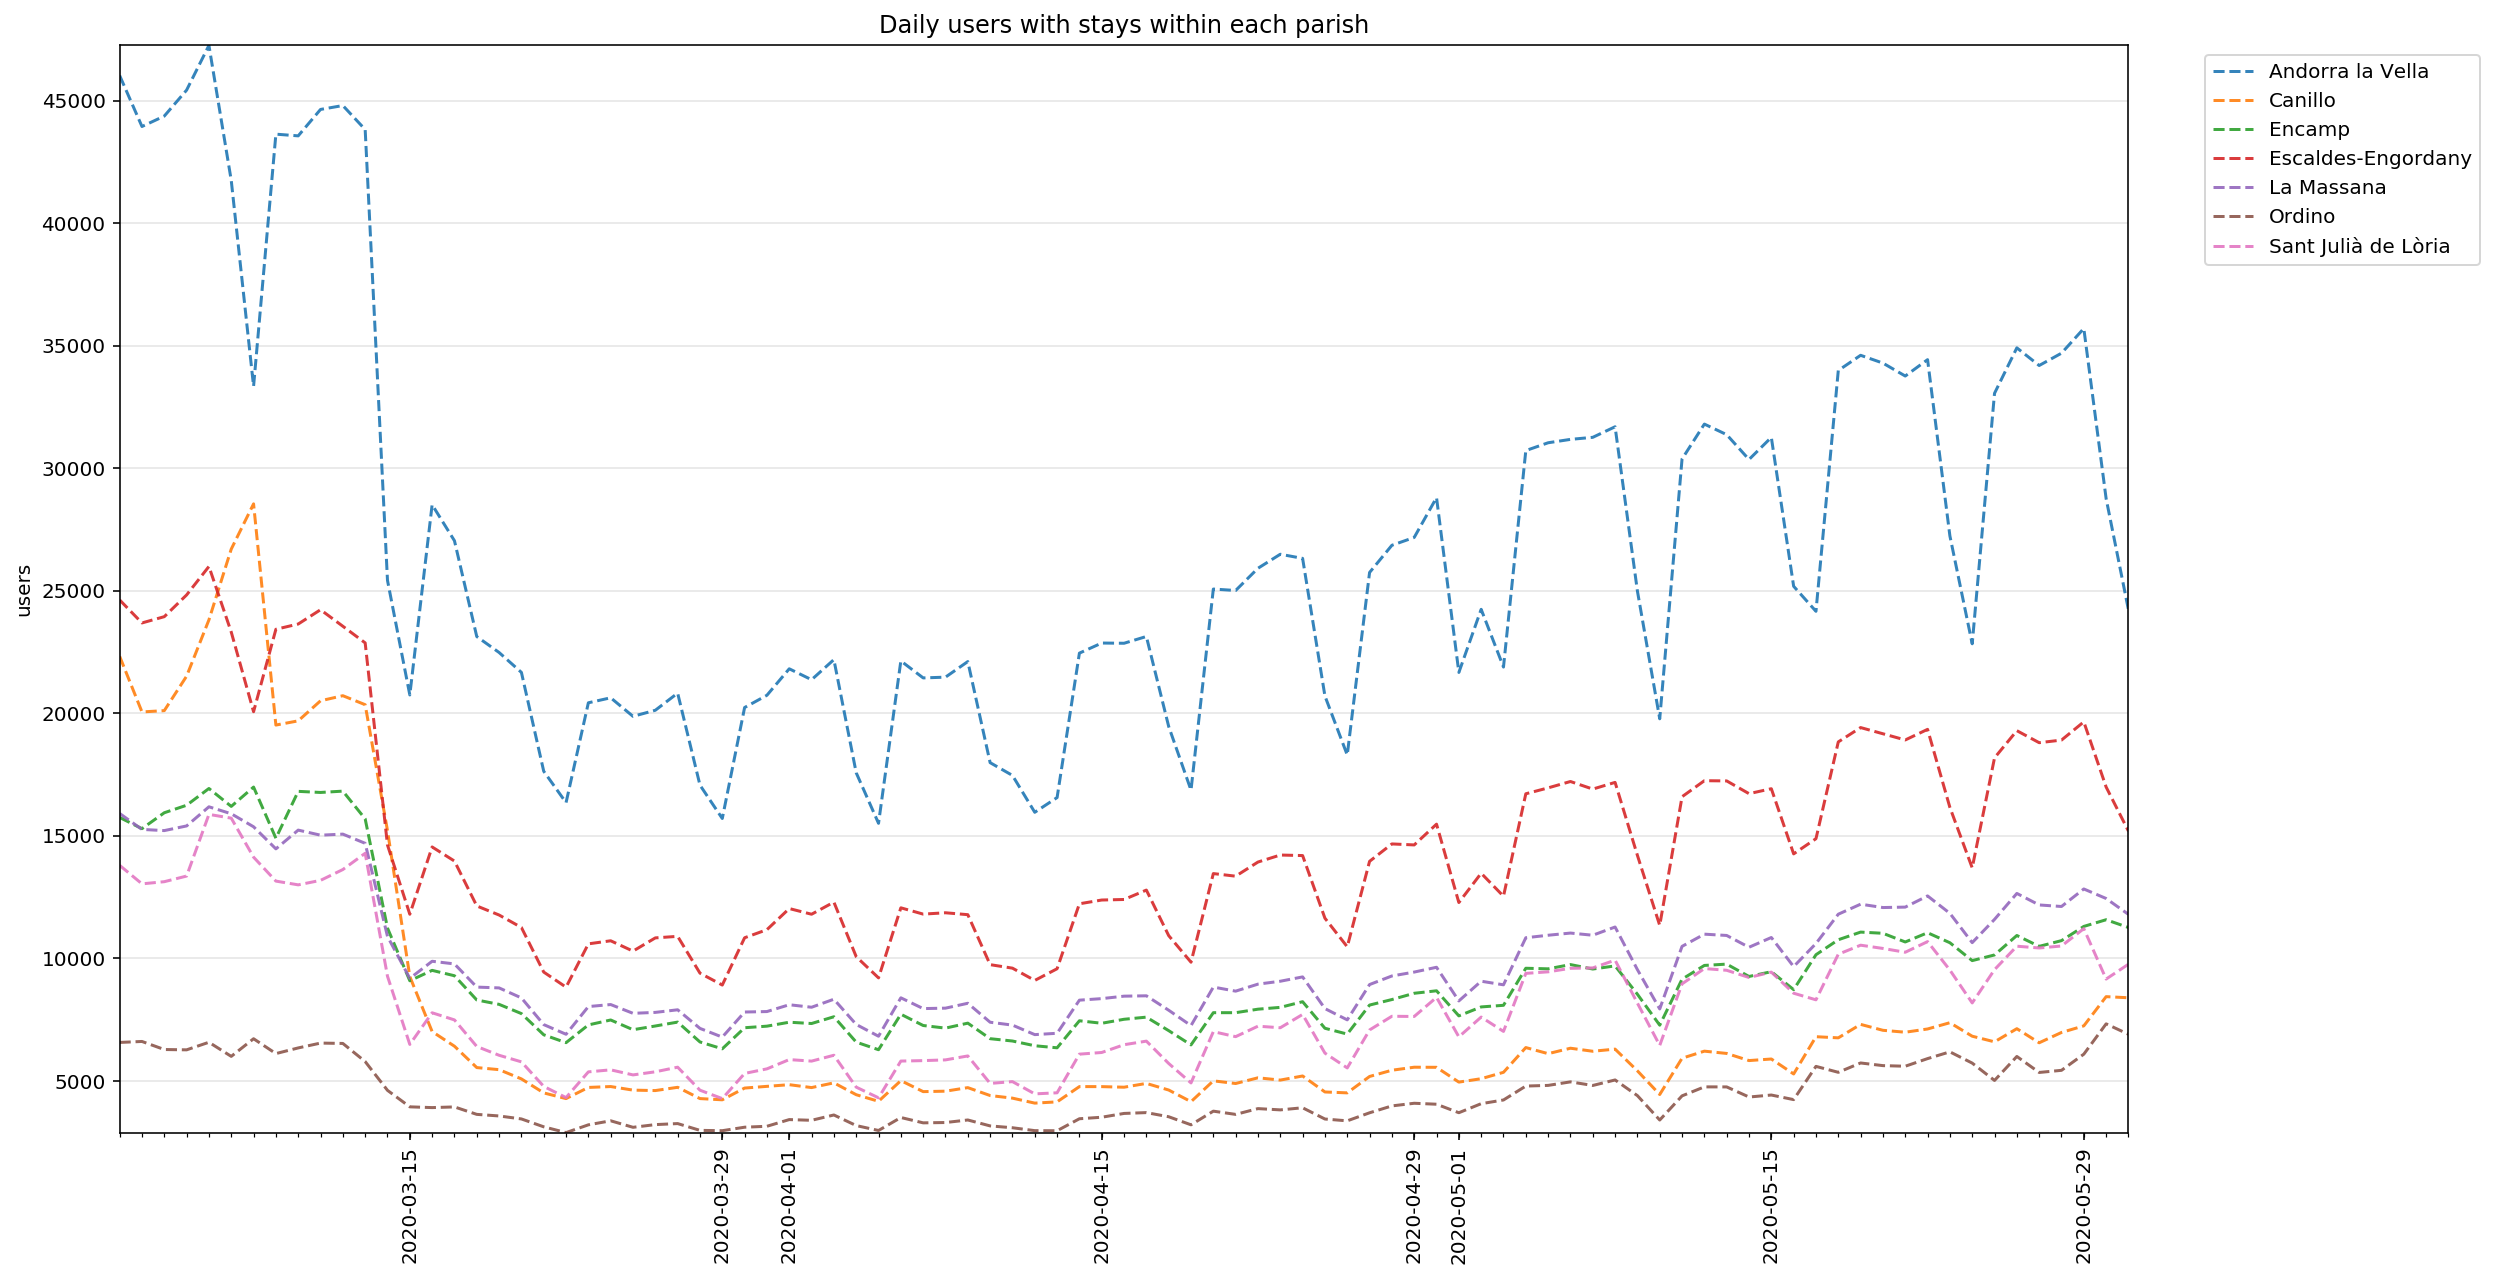

In [57]:
figure, ax = plt.subplots(figsize=(18, 10))

for i, parish in enumerate(parishes):
    p_df = trips_within_parish_2020_df[trips_within_parish_2020_df[PARISH_NAME]==parish]
    index = p_df[DATE]
    ax.plot(index,
            p_df[USER_COUNT],
            label='%s'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle='--',
    ) 
    ax.set_ylabel('users')
    ax.set_title('Daily users with stays within each parish')
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend(bbox_to_anchor=(1.18, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

## Daily users making trips *between* parishes


a. Daily users making trips into parishes

b. Daily users making trips out of parishes

Where we analyze the where the users are coming from or going to - i.e. the origins and  destinations at once.

A trip between 2 parishes, A and B, is counted when a user has a stay in parish A that is directly followed by a stay in parish B.  


Make a  table:
`
date, origin parish, destination parish, trips, users
`




In [60]:
ORIGIN_PARISH = 'origin parish'
DESTINATION_PARISH = 'destination parish'
TOTAL_TRIPS = 'trips'

In [65]:
def get_trips_between_parishes_df(dates):
    trips_between_parishes_records = []
    for i, d in enumerate(dates):
        stays_filepath = get_stays_filepath(d.day, d.month, d.year)
        date_str =  d.strftime("%Y-%m-%d")
        print('%s/%s %s' %  (i, len(dates), date_str))
        if not pathlib.Path(stays_filepath).is_file():
            print('skipping %s -- file not found: %s' % (date_str, stays_filepath))
            continue
        df = pd.read_csv(stays_filepath)[[IMSI, PARISH_NAME, STAY_START]]
        df.sort_values([IMSI,STAY_START],inplace=True)
        df['prev imsi'] = df[IMSI].shift()
        df['prev parish'] = df[PARISH_NAME].shift()
        for origin_parish in parishes:
            for destination_parish in parishes:
                if origin_parish == destination_parish:
                    continue
                od_df = df[(df[IMSI]==df['prev imsi']) \
                           & (df['prev parish']==origin_parish) \
                           & (df[PARISH_NAME]==destination_parish)]

                trips_between_parishes_records  +=  [{
                    DATE: d,
                    ORIGIN_PARISH: origin_parish,
                    DESTINATION_PARISH: destination_parish,
                    TOTAL_TRIPS: len(od_df),
                    USER_COUNT: od_df[IMSI].nunique(),
                }]
    trips_between_parishes_df = pd.DataFrame.from_records(trips_between_parishes_records)
    return trips_between_parishes_df
    

In [66]:
trips_between_parishes_2020_df = get_trips_between_parishes_df(dates_2020)
trips_between_parishes_2019_df = get_trips_between_parishes_df(dates_2019)
trips_between_parishes_2020_df.head()

0/92 2020-03-02
1/92 2020-03-03
2/92 2020-03-04
3/92 2020-03-05
4/92 2020-03-06
5/92 2020-03-07
6/92 2020-03-08
7/92 2020-03-09
8/92 2020-03-10
9/92 2020-03-11
10/92 2020-03-12
11/92 2020-03-13
12/92 2020-03-14
13/92 2020-03-15
14/92 2020-03-16
15/92 2020-03-17
16/92 2020-03-18
17/92 2020-03-19
18/92 2020-03-20
19/92 2020-03-21
20/92 2020-03-22
21/92 2020-03-23
22/92 2020-03-24
23/92 2020-03-25
24/92 2020-03-26
25/92 2020-03-27
26/92 2020-03-28
27/92 2020-03-29
28/92 2020-03-30
29/92 2020-03-31
30/92 2020-04-01
31/92 2020-04-02
32/92 2020-04-03
33/92 2020-04-04
34/92 2020-04-05
35/92 2020-04-06
36/92 2020-04-07
37/92 2020-04-08
38/92 2020-04-09
39/92 2020-04-10
40/92 2020-04-11
41/92 2020-04-12
42/92 2020-04-13
43/92 2020-04-14
44/92 2020-04-15
45/92 2020-04-16
46/92 2020-04-17
47/92 2020-04-18
48/92 2020-04-19
49/92 2020-04-20
50/92 2020-04-21
51/92 2020-04-22
52/92 2020-04-23
53/92 2020-04-24
54/92 2020-04-25
55/92 2020-04-26
56/92 2020-04-27
57/92 2020-04-28
58/92 2020-04-29
59/92 2

date  destination parish     origin parish  trips  users
0 2020-03-02             Canillo  Andorra la Vella   3924   2635
1 2020-03-02              Encamp  Andorra la Vella   6248   3915
2 2020-03-02  Escaldes-Engordany  Andorra la Vella  21417  12500
3 2020-03-02          La Massana  Andorra la Vella   8997   5457
4 2020-03-02              Ordino  Andorra la Vella   2567   1772

Plot:

Daily total trips into each parish and out of  each parish

And

Daily unique users traveling in and out of each parish

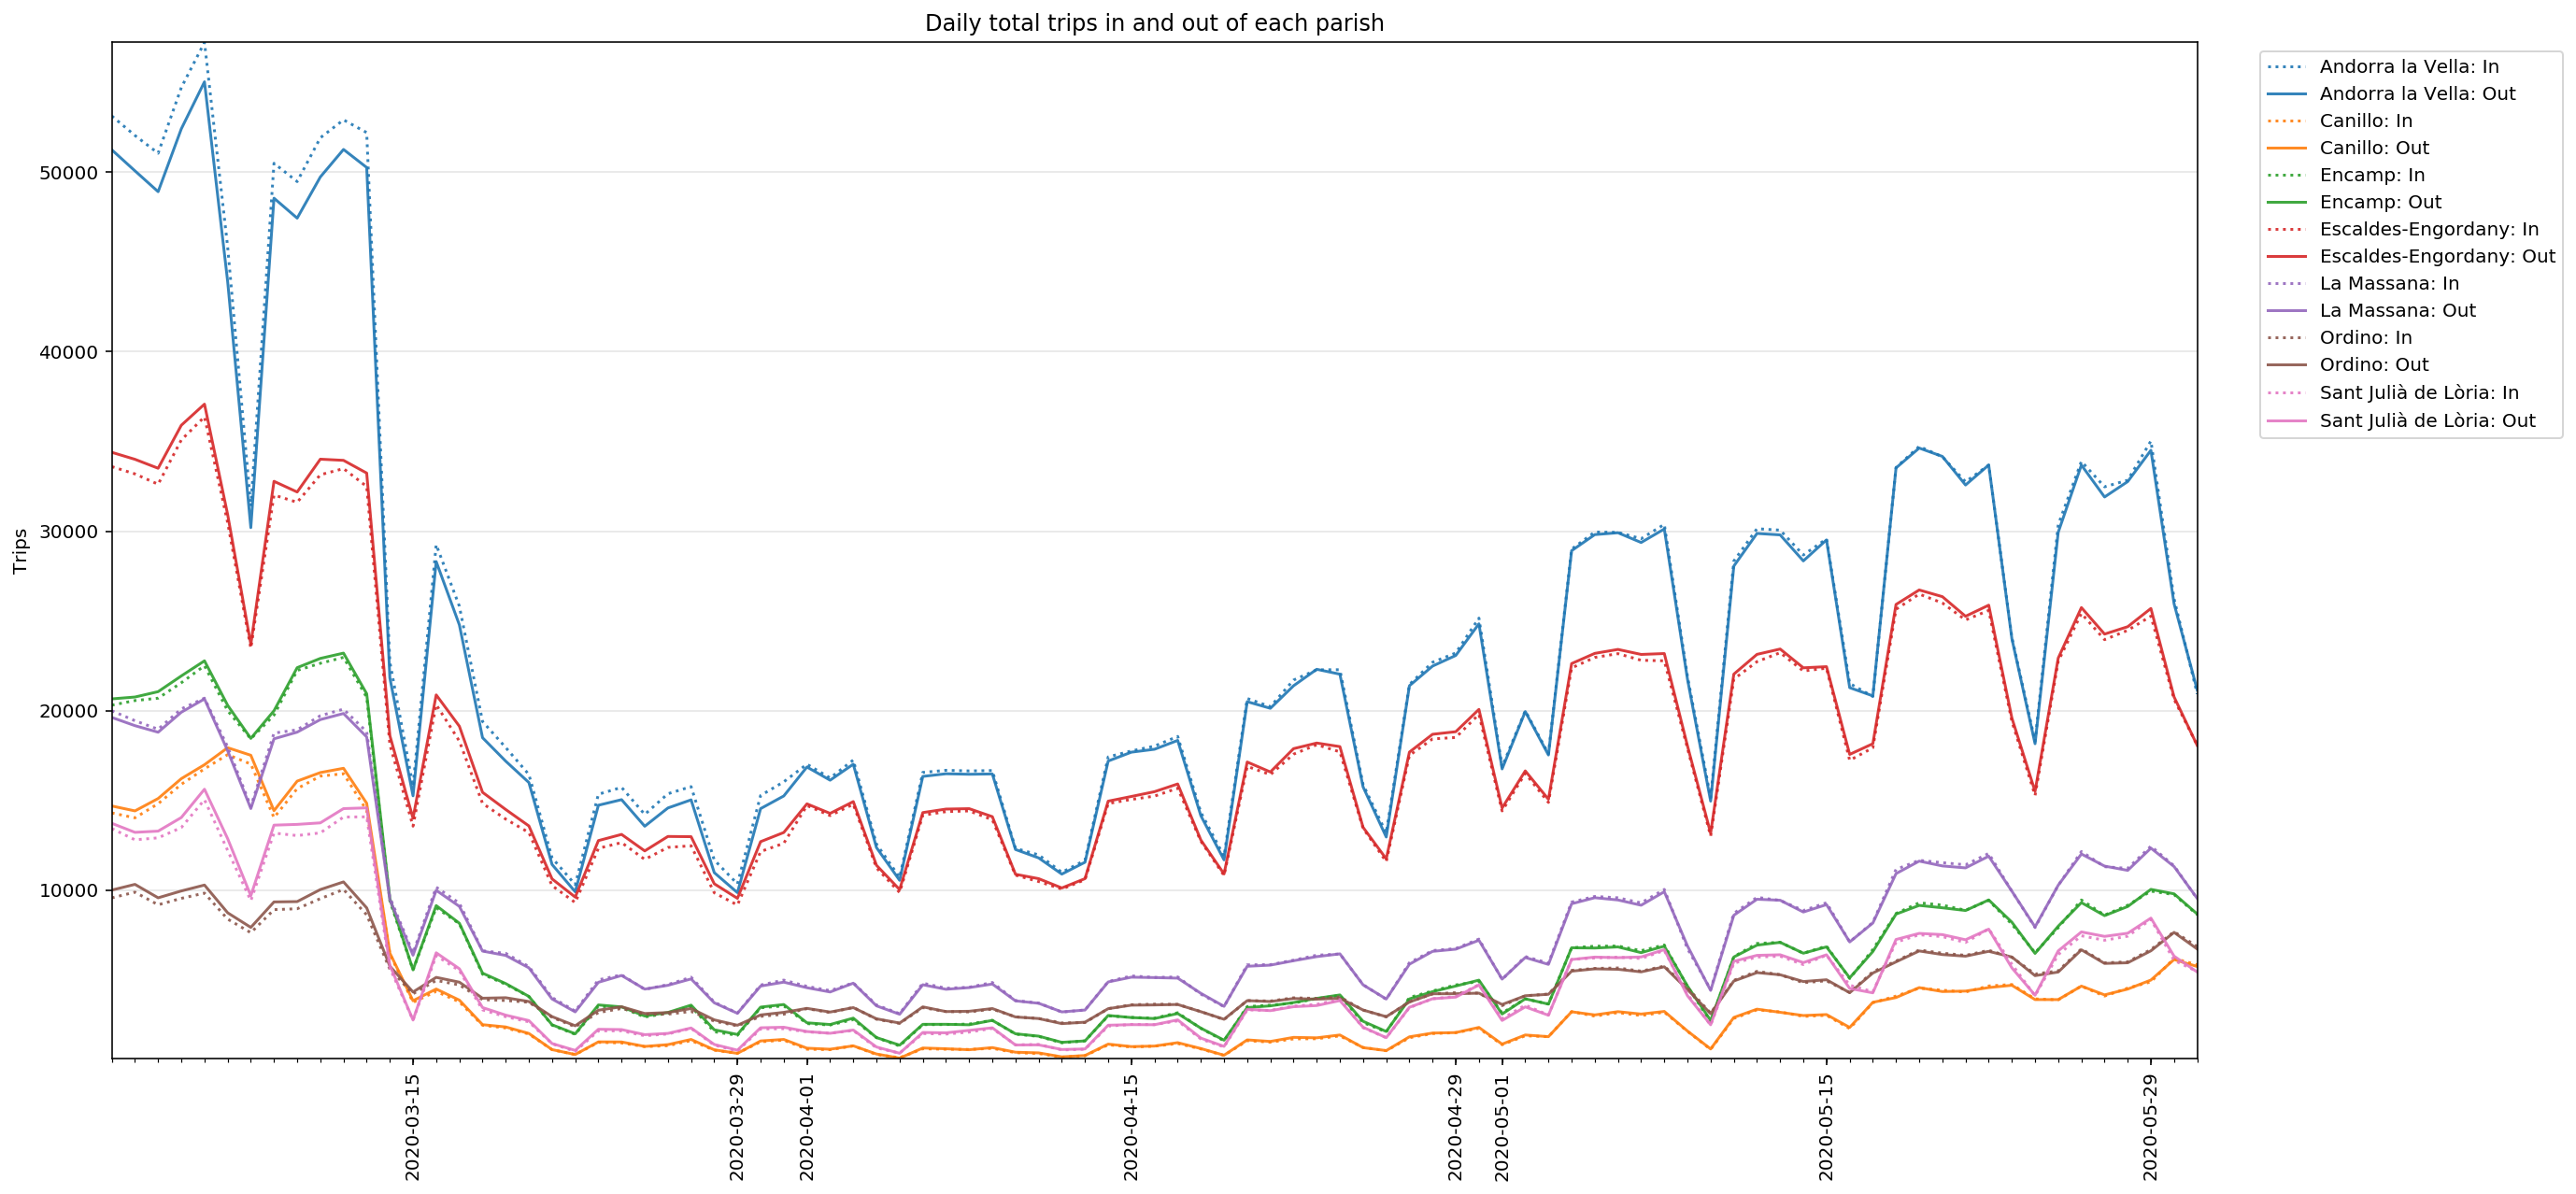

In [67]:
figure, ax = plt.subplots(figsize=(20, 10))

for i, parish in enumerate(parishes):
    p_in_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[DESTINATION_PARISH]==parish]
    p_in_df = p_in_df.groupby(DATE).sum().reset_index()
    p_out_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[ORIGIN_PARISH]==parish]
    p_out_df =  p_out_df.groupby(DATE).sum().reset_index()
    index = p_in_df[DATE]
    ax.plot(index,
            p_in_df[TOTAL_TRIPS],
            label='%s: In'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle=':',
    )
    ax.plot(index,
            p_out_df[TOTAL_TRIPS],
            label='%s: Out'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle='-',
    )
    ax.set_ylabel('Trips')
    ax.set_title('Daily total trips in and out of each parish')
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend(bbox_to_anchor=(1.18, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

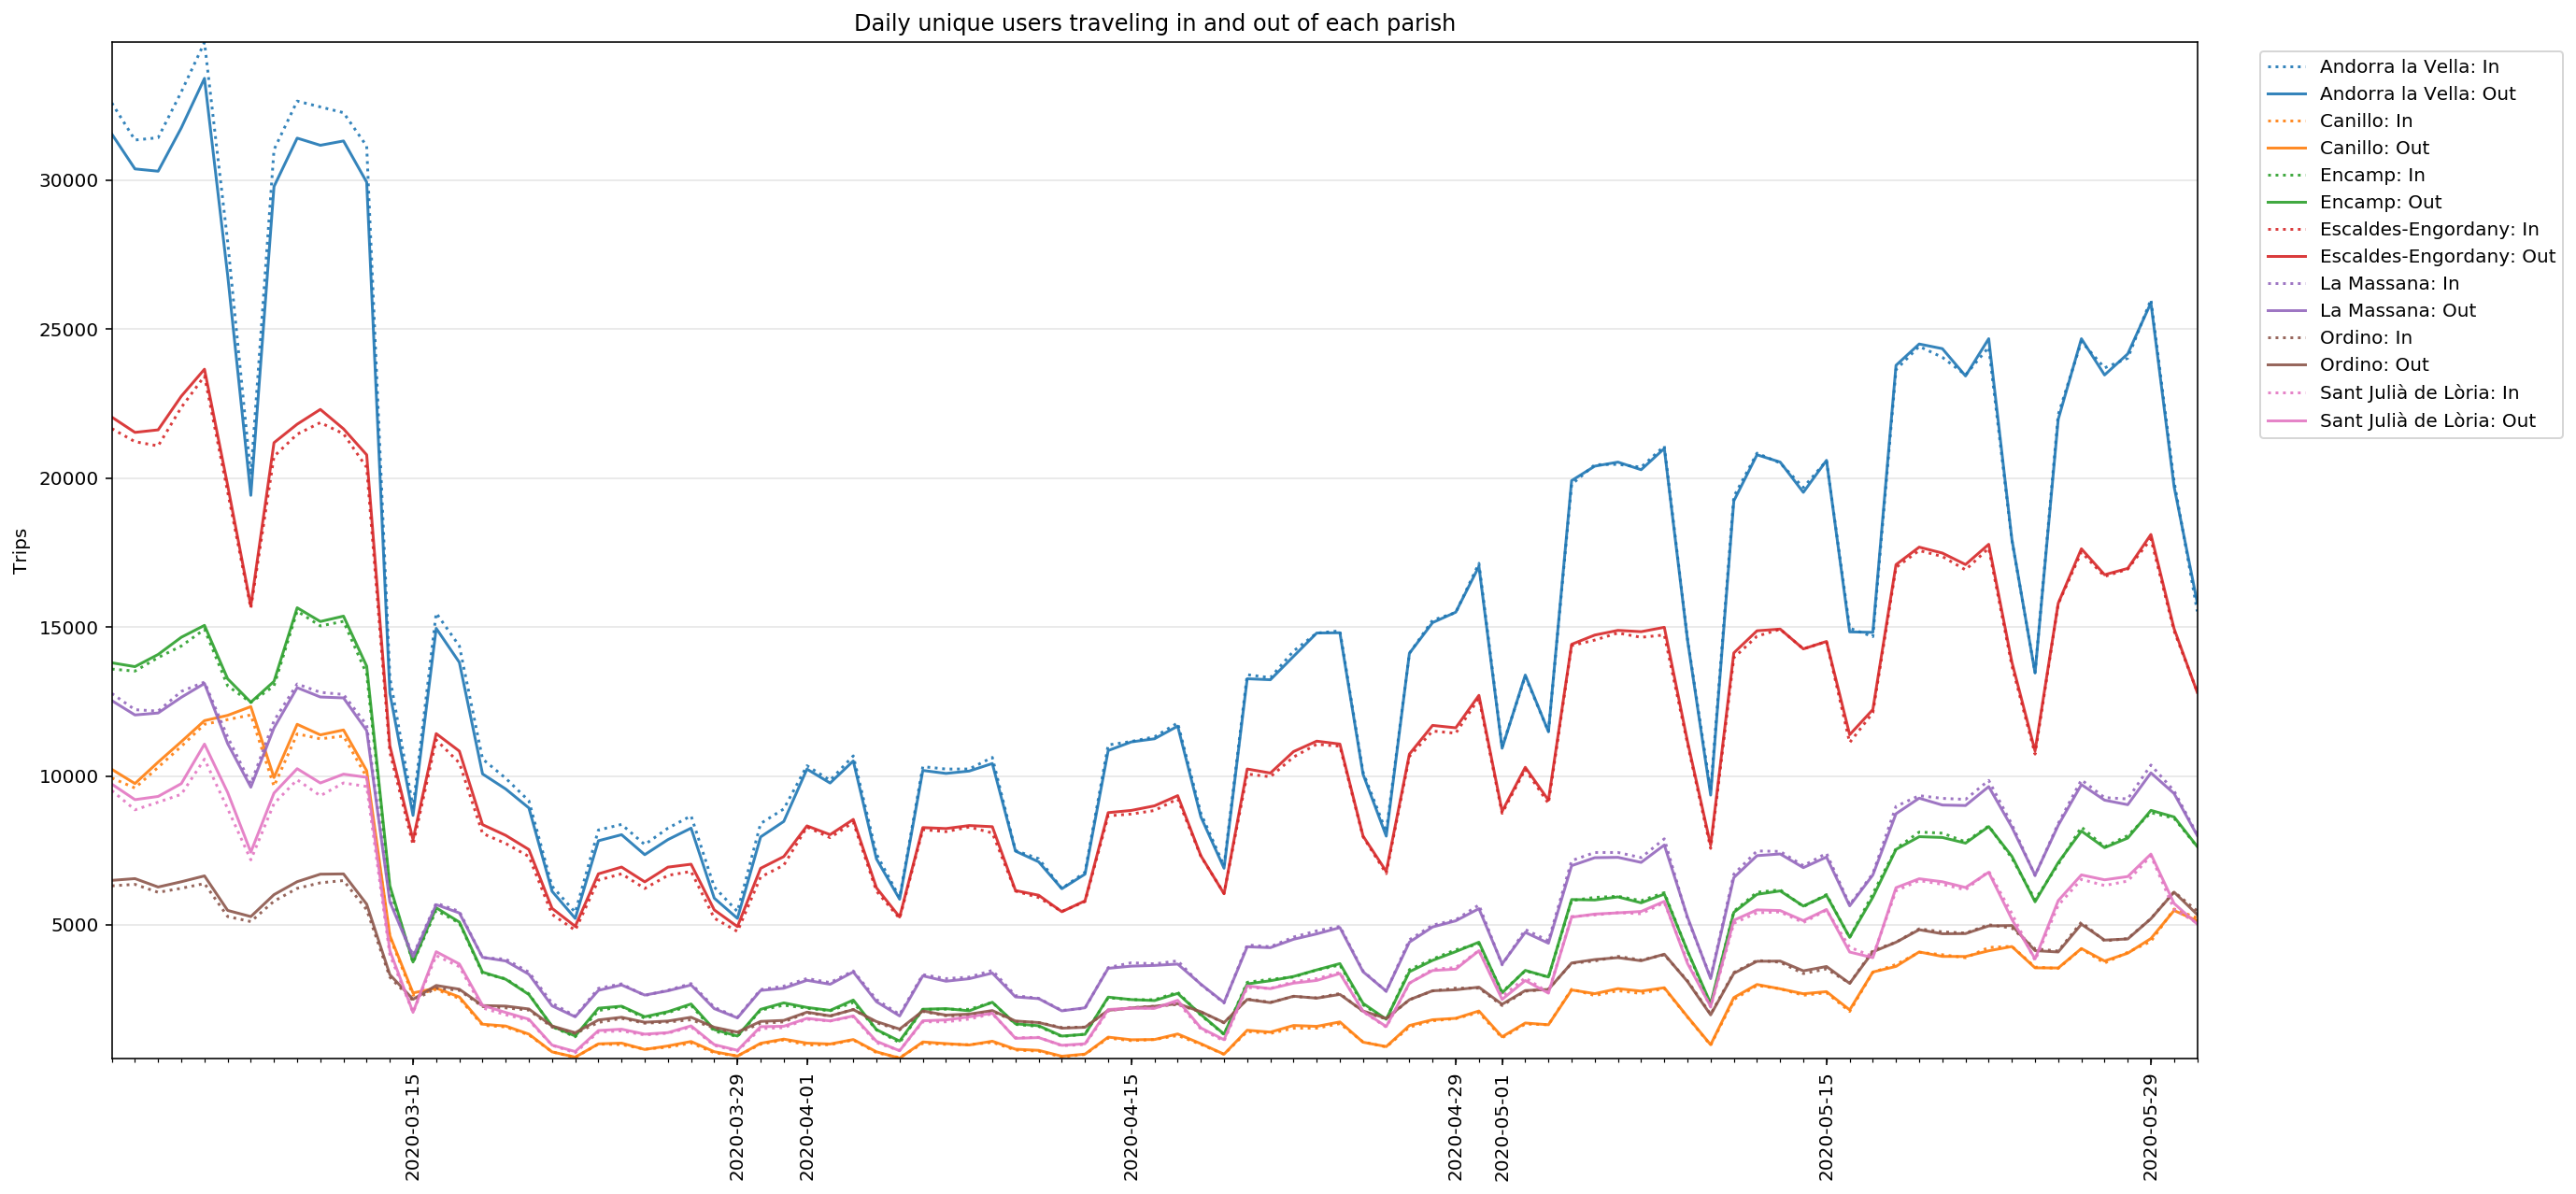

In [69]:
figure, ax = plt.subplots(figsize=(20, 10))

for i, parish in enumerate(parishes):
    p_in_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[DESTINATION_PARISH]==parish]
    p_in_df = p_in_df.groupby(DATE).sum().reset_index()
    p_out_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[ORIGIN_PARISH]==parish]
    p_out_df =  p_out_df.groupby(DATE).sum().reset_index()
    index = p_in_df[DATE]
    ax.plot(index,
            p_in_df[USER_COUNT],
            label='%s: In'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle=':',
    )
    ax.plot(index,
            p_out_df[USER_COUNT],
            label='%s: Out'%parish,
            alpha=0.9,
            color=cmap(i),
            linestyle='-',
    )
    ax.set_ylabel('Trips')
    ax.set_title('Daily unique users traveling in and out of each parish')
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend(bbox_to_anchor=(1.18, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

Plot the daily unique users traveling into each Parish

And comare 2019 v 2020

In [129]:
def make_trips_into_parishes_plot(df, year, ax=None, legend=True):
    if not ax:
        figure, ax = plt.subplots(figsize=(20, 6))
    for i, parish in enumerate(parishes):
        p_in_df = df[df[DESTINATION_PARISH]==parish]
        p_in_df = p_in_df.groupby(DATE).sum().reset_index()
        # reformat date
        p_in_df['day'] = p_in_df[DATE].apply(lambda d: d.strftime('%b/%d'))
        index = p_in_df['day']
        ax.plot(index,
                p_in_df[USER_COUNT],
                label='%s'%parish,
                alpha=0.9,
                color=cmap(i),
                linestyle='-',
        )
        ax.set_ylabel('trips')
        title = 'Daily unique users traveling into each parish'
        ax.set_title(('%s: '+title) % year)
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.margins(0)
        ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
        ax.legend(facecolor=COLOR, framealpha=0)
        if not legend:
            ax.get_legend().remove()
        ax.tick_params(axis='x', labelrotation=90)


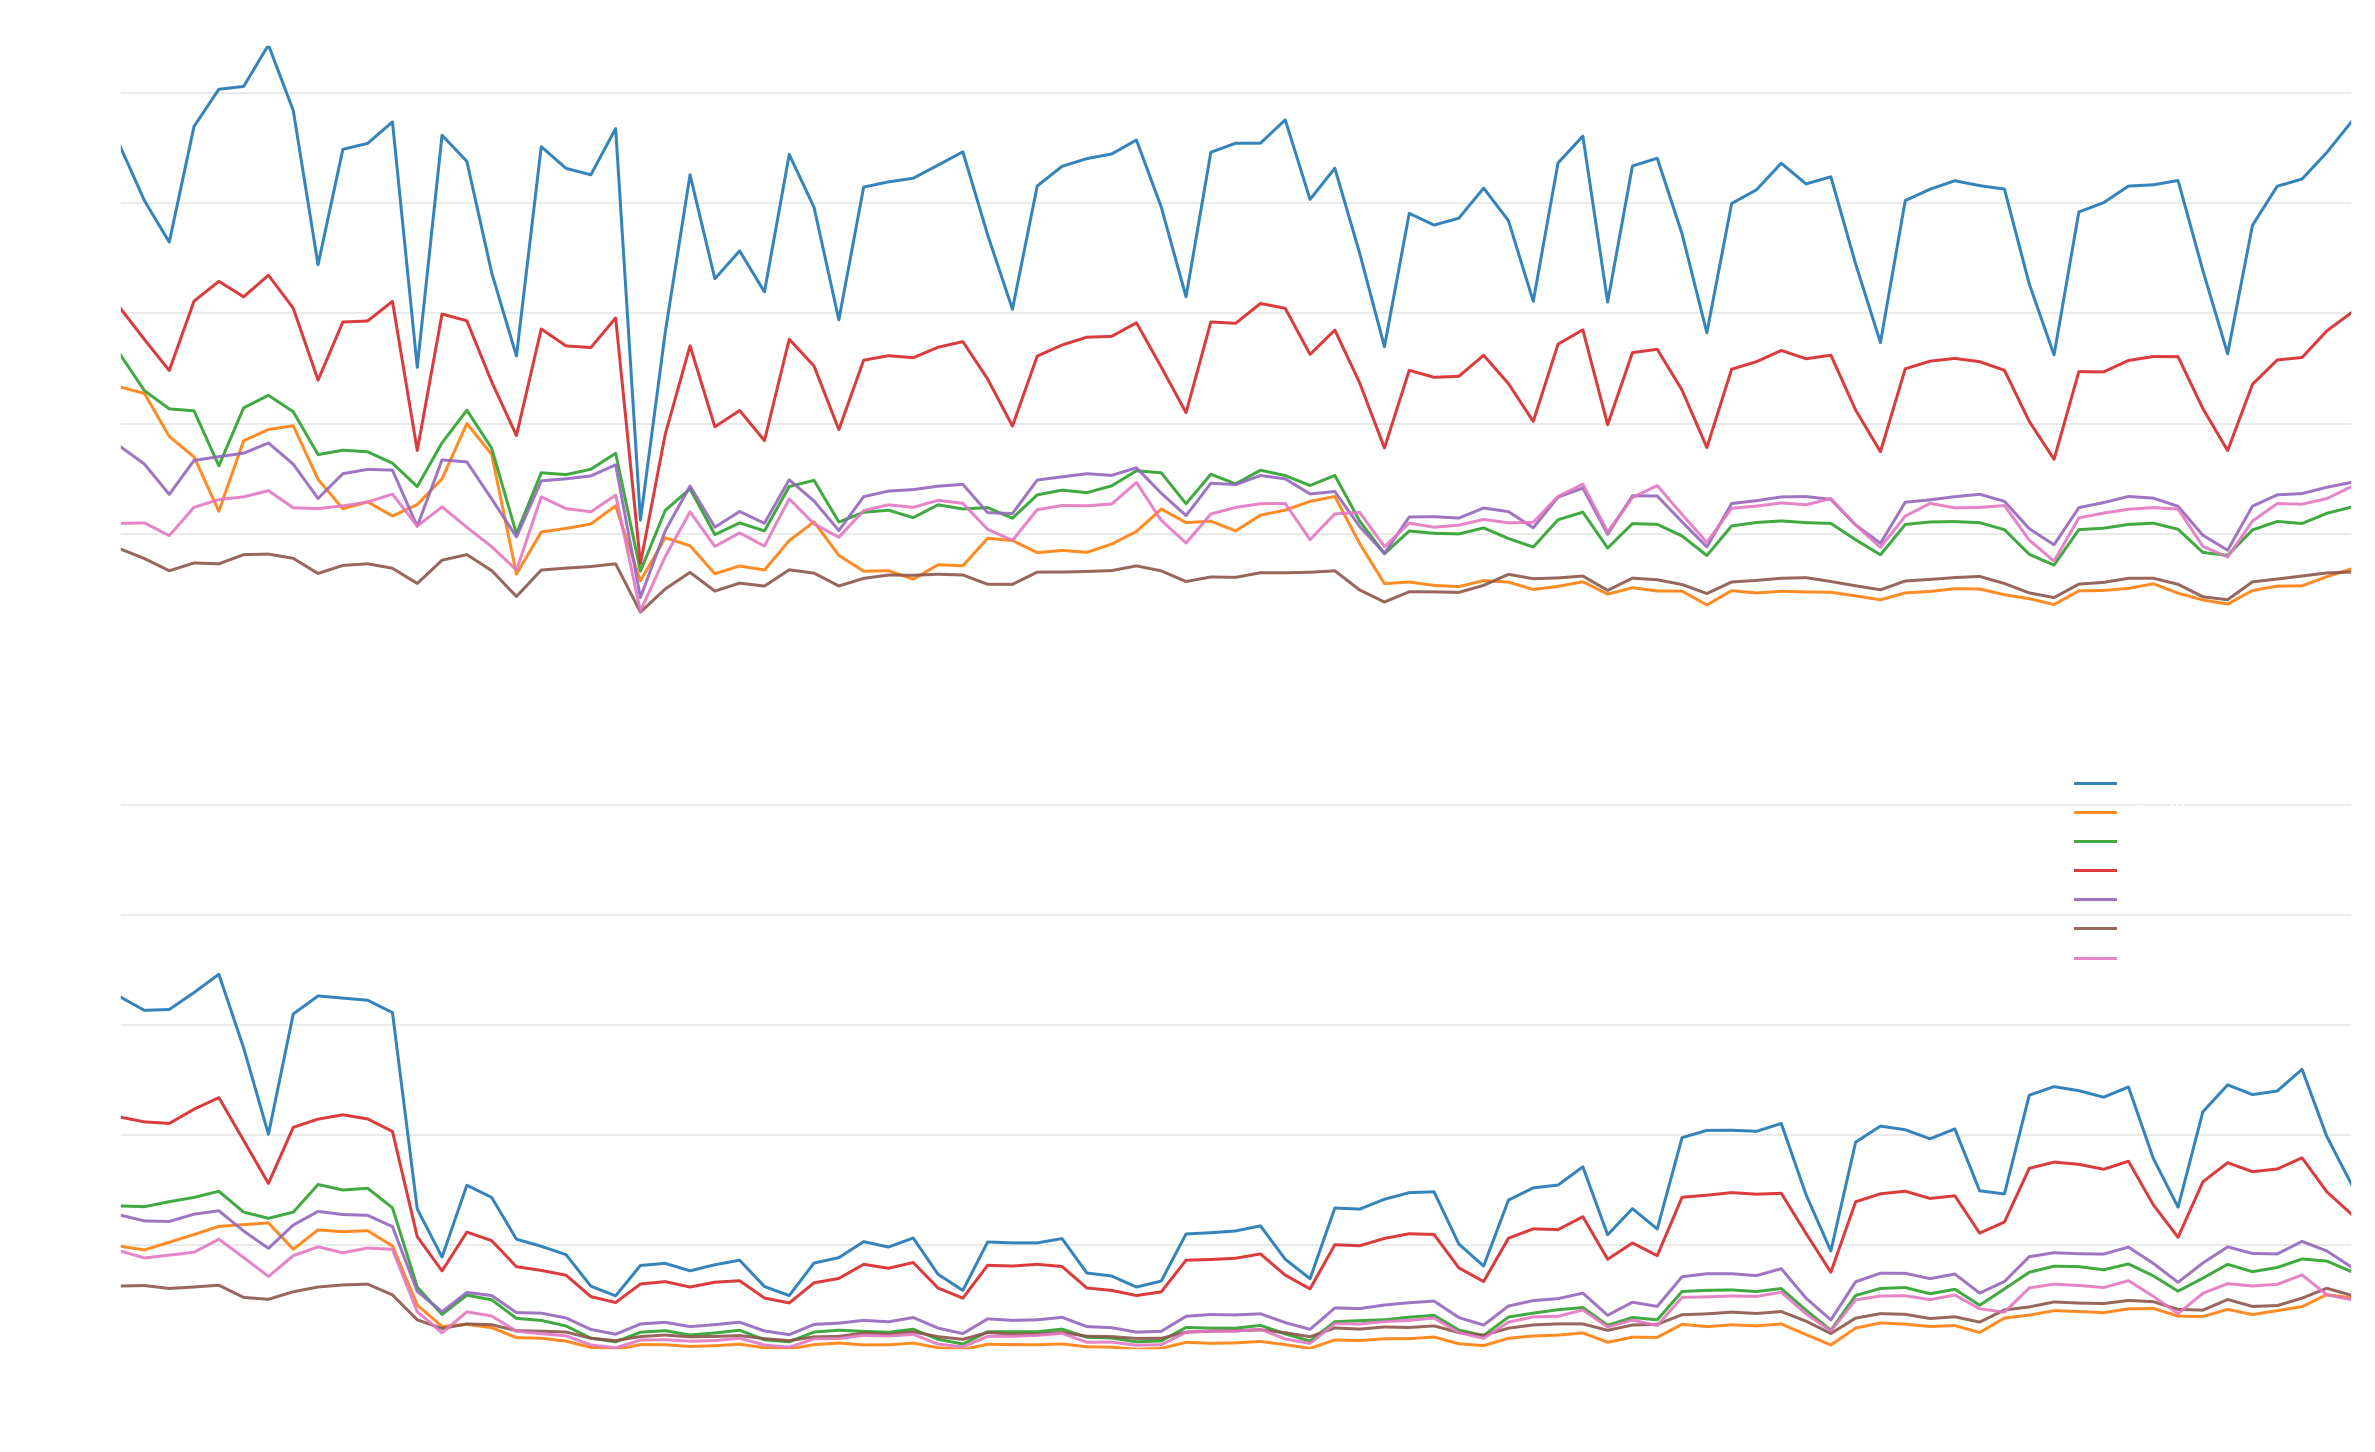

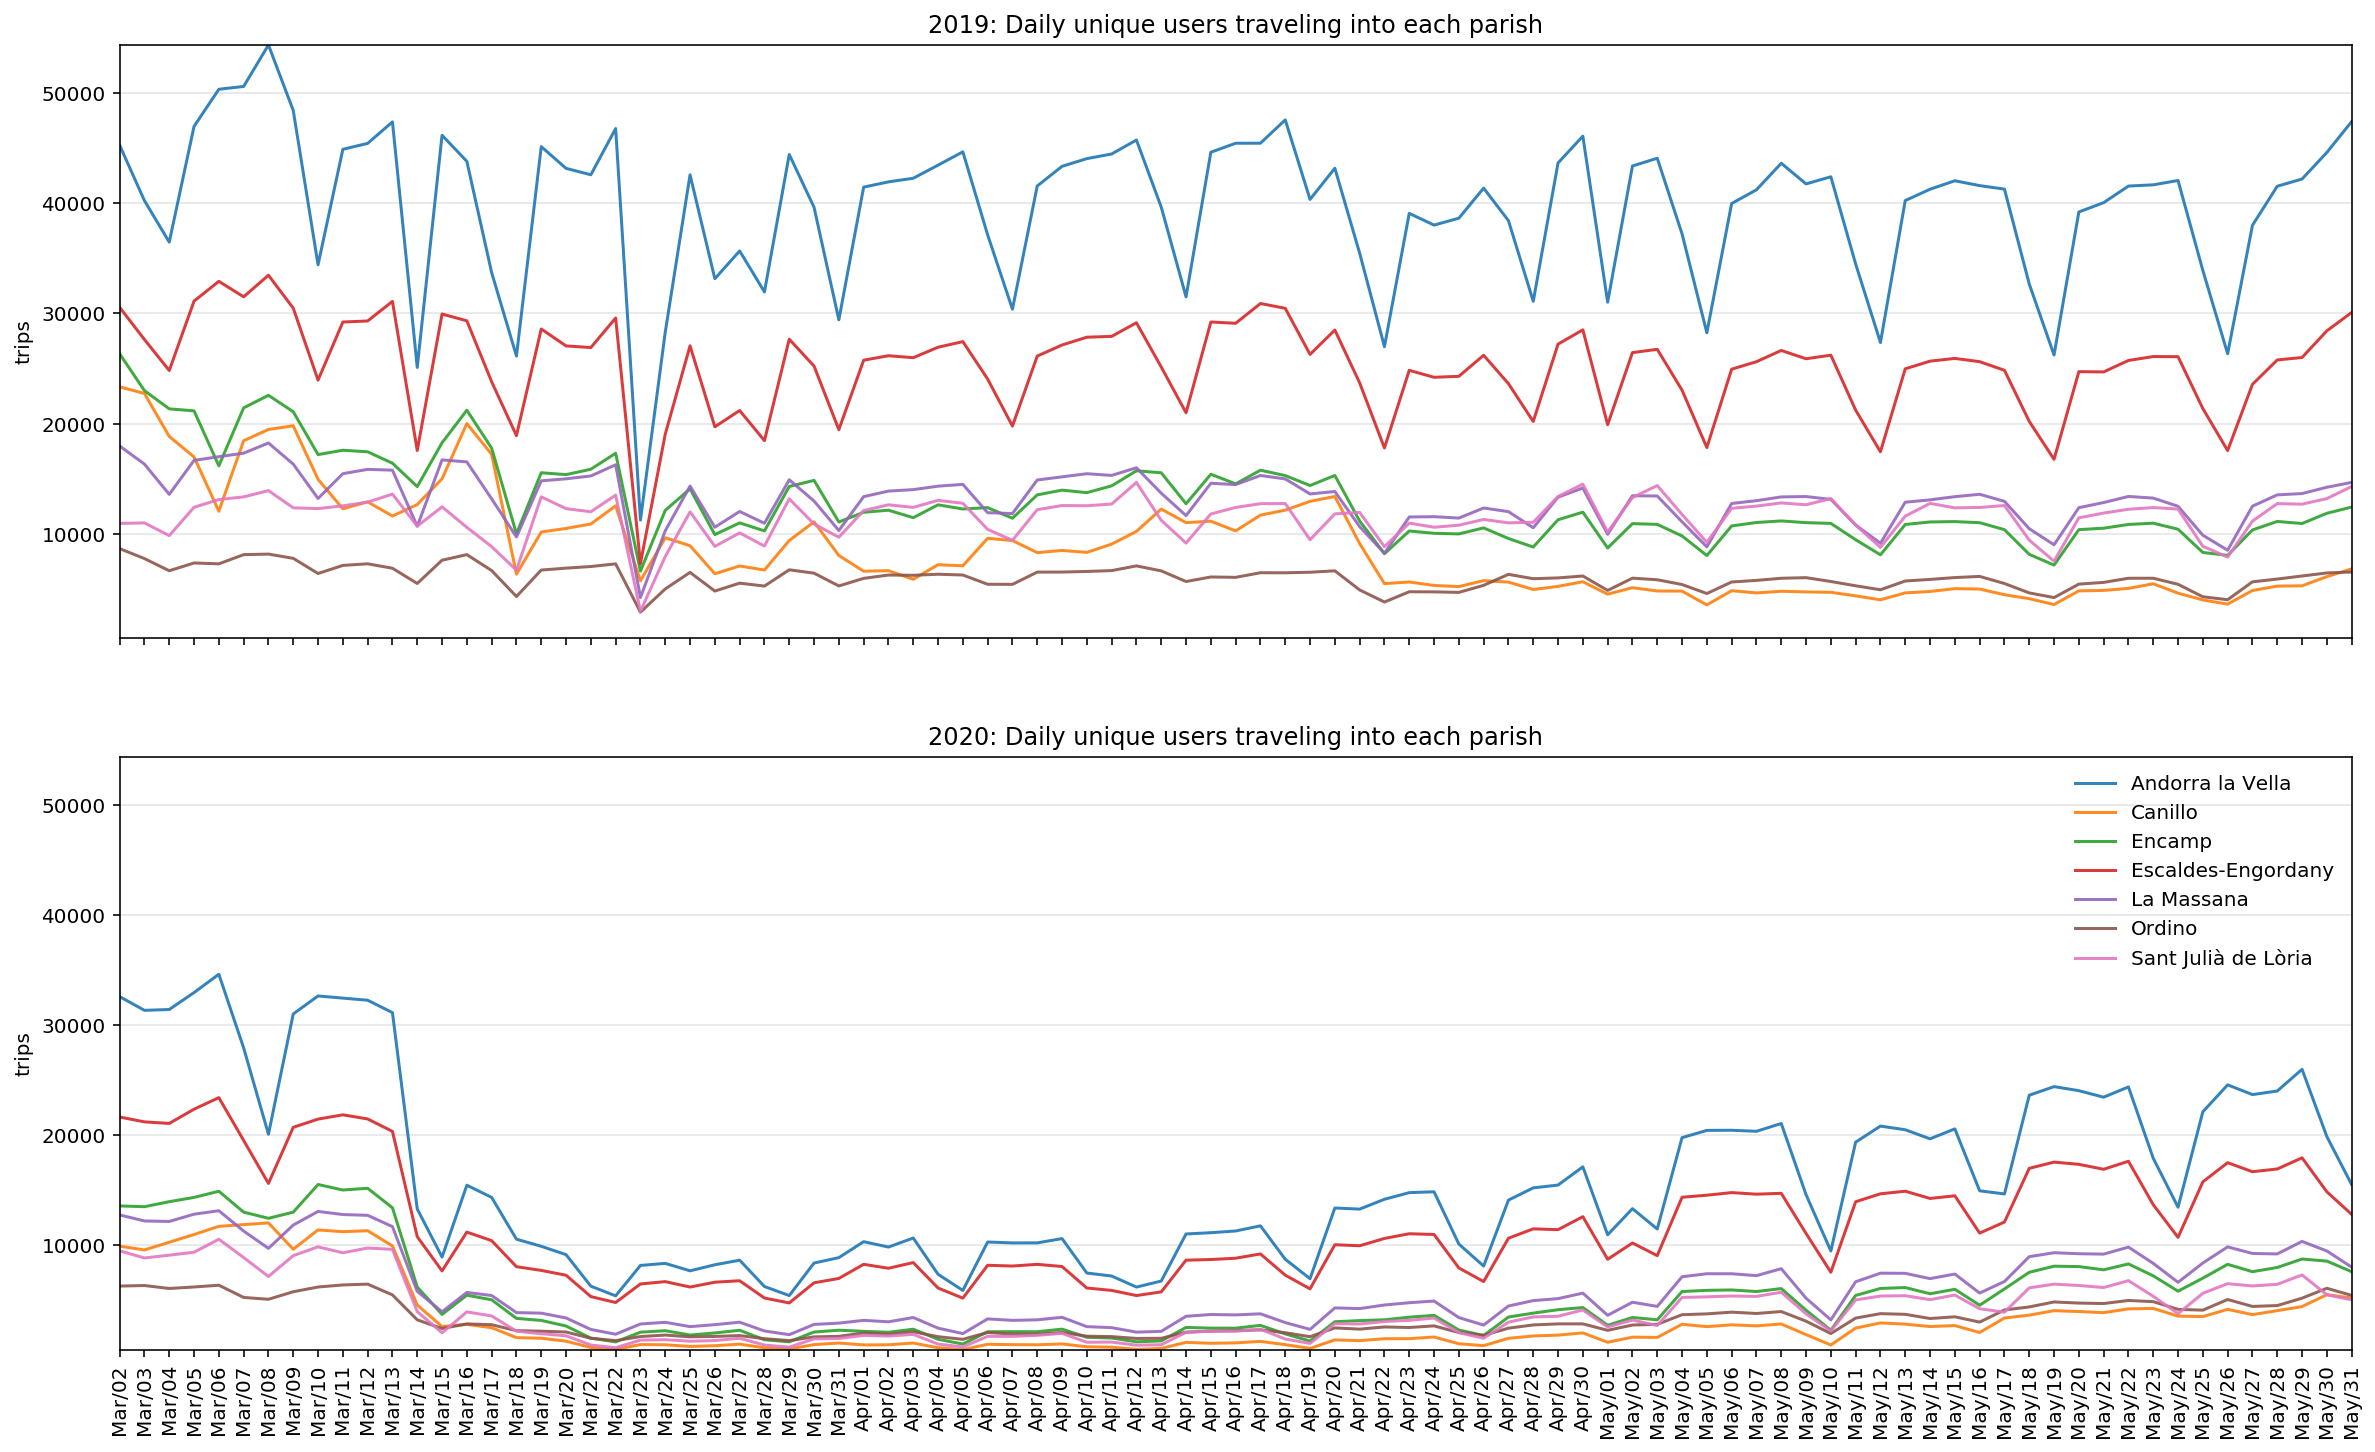

In [130]:
COLOR='white'
set_colors(COLOR)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)
make_trips_into_parishes_plot(trips_between_parishes_2019_df, 
                    2019, ax=ax1,legend=False)
make_trips_into_parishes_plot(trips_between_parishes_2020_df, 
                    2020, ax=ax2)
plt.setp(ax1.spines.values(), color=COLOR)
plt.setp(ax2.spines.values(), color=COLOR)
plt.show()

COLOR='black'
set_colors(COLOR)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)
make_trips_into_parishes_plot(trips_between_parishes_2019_df, 
                    2019, ax=ax1,legend=False)
make_trips_into_parishes_plot(trips_between_parishes_2020_df, 
                    2020, ax=ax2)
plt.setp(ax1.spines.values(), color=COLOR)
plt.setp(ax2.spines.values(), color=COLOR)
plt.show()

Plot: 

The origin of trips into each parish

and 

The destination of trips out of each parish

In [76]:
parish_colors = {parish: cmap(i) for i, parish in enumerate(parishes)}

In [131]:
# reformat date
trips_between_parishes_2020_df.head()

date  destination parish     origin parish  trips  users     day
0 2020-03-02             Canillo  Andorra la Vella   3924   2635  Mar/02
1 2020-03-02              Encamp  Andorra la Vella   6248   3915  Mar/02
2 2020-03-02  Escaldes-Engordany  Andorra la Vella  21417  12500  Mar/02
3 2020-03-02          La Massana  Andorra la Vella   8997   5457  Mar/02
4 2020-03-02              Ordino  Andorra la Vella   2567   1772  Mar/02

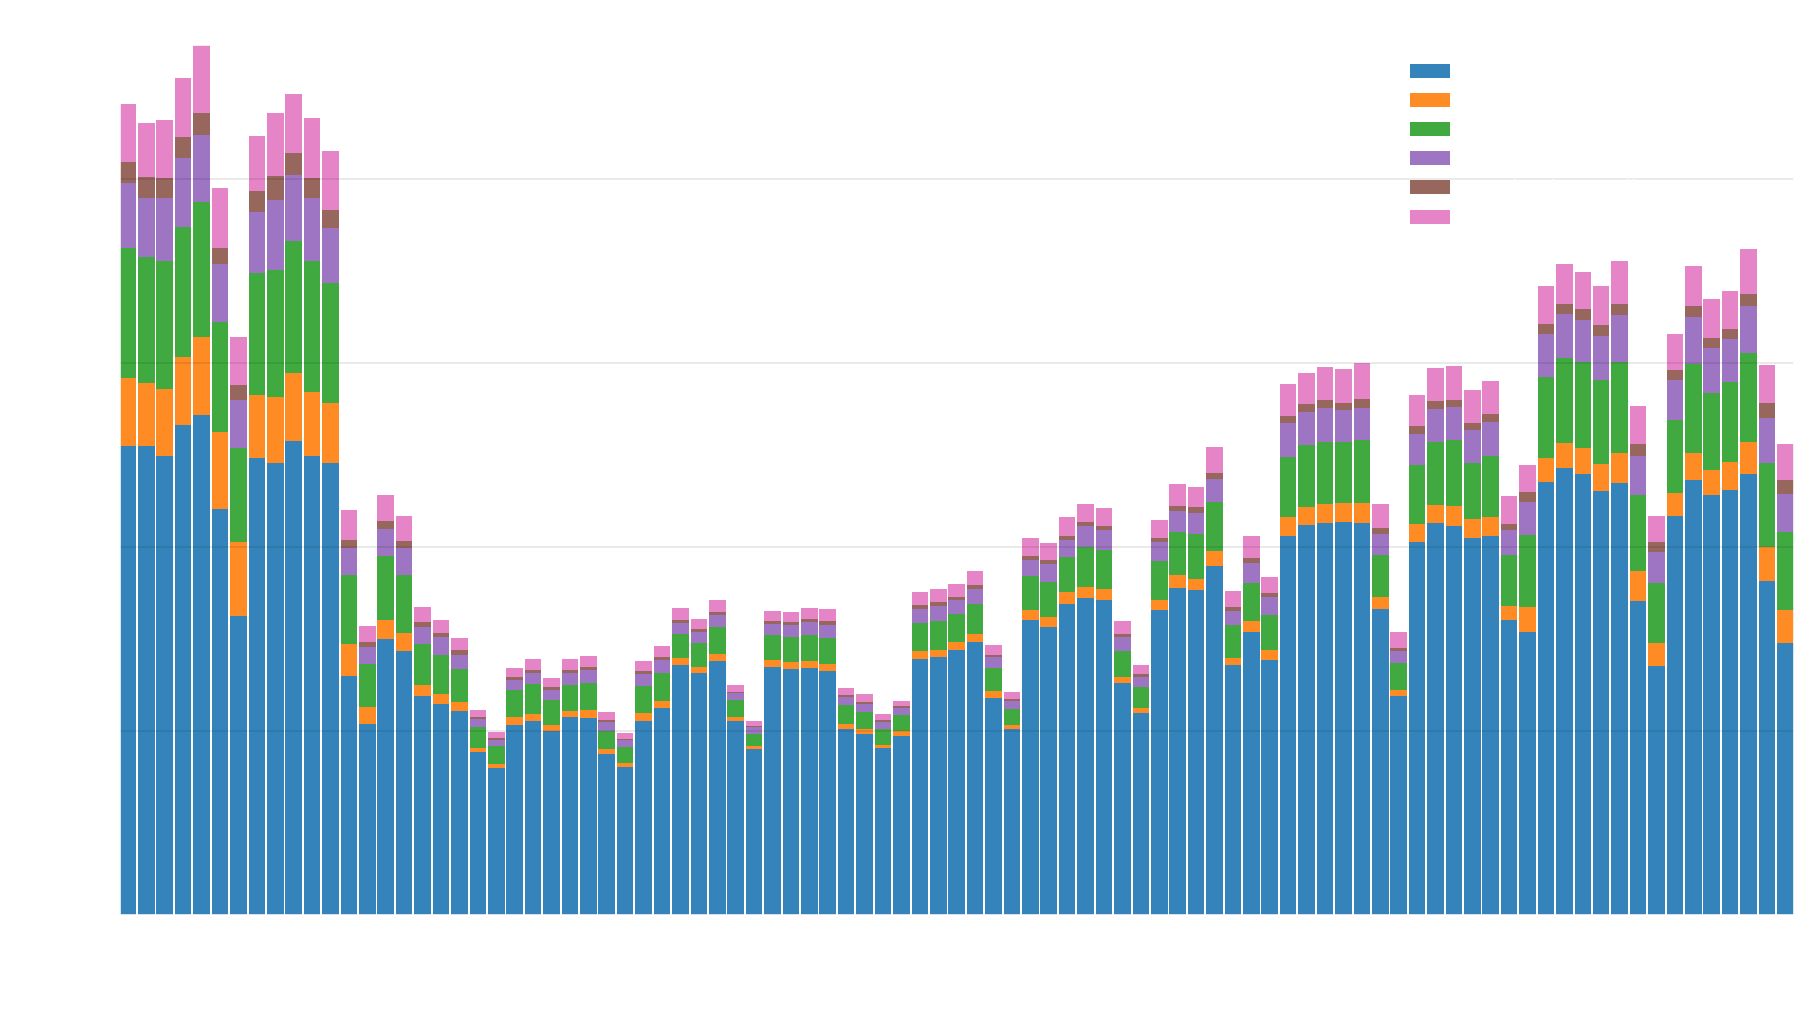

In [137]:
# show just one parish here


COLOR='white'
set_colors(COLOR)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.15)

o_parish = 'Escaldes-Engordany'

bottom = None
p_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[ORIGIN_PARISH]==o_parish]
for d_parish in parishes:
    if o_parish == d_parish:
        continue
    od_p_df = p_df[p_df[DESTINATION_PARISH]==d_parish]
    index = od_p_df['day']
    users = od_p_df[USER_COUNT]
    ax.bar(index,
           users, 
           0.9, 
           color=parish_colors[d_parish],
           label='Destination: %s'%d_parish,
           alpha=0.9,
           bottom=bottom,
          )
    if bottom is  None:
        bottom = np.array(users)
    else:
        bottom += np.array(users)
ax.set_ylabel('Users')
ax.set_title('%s: Daily number of users making trips out to another parish' % o_parish)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.margins(0)
ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.legend(facecolor=COLOR, framealpha=0)
ax.tick_params(axis='x', labelrotation=90)
plt.setp(ax.spines.values(), color=COLOR)

plt.show()

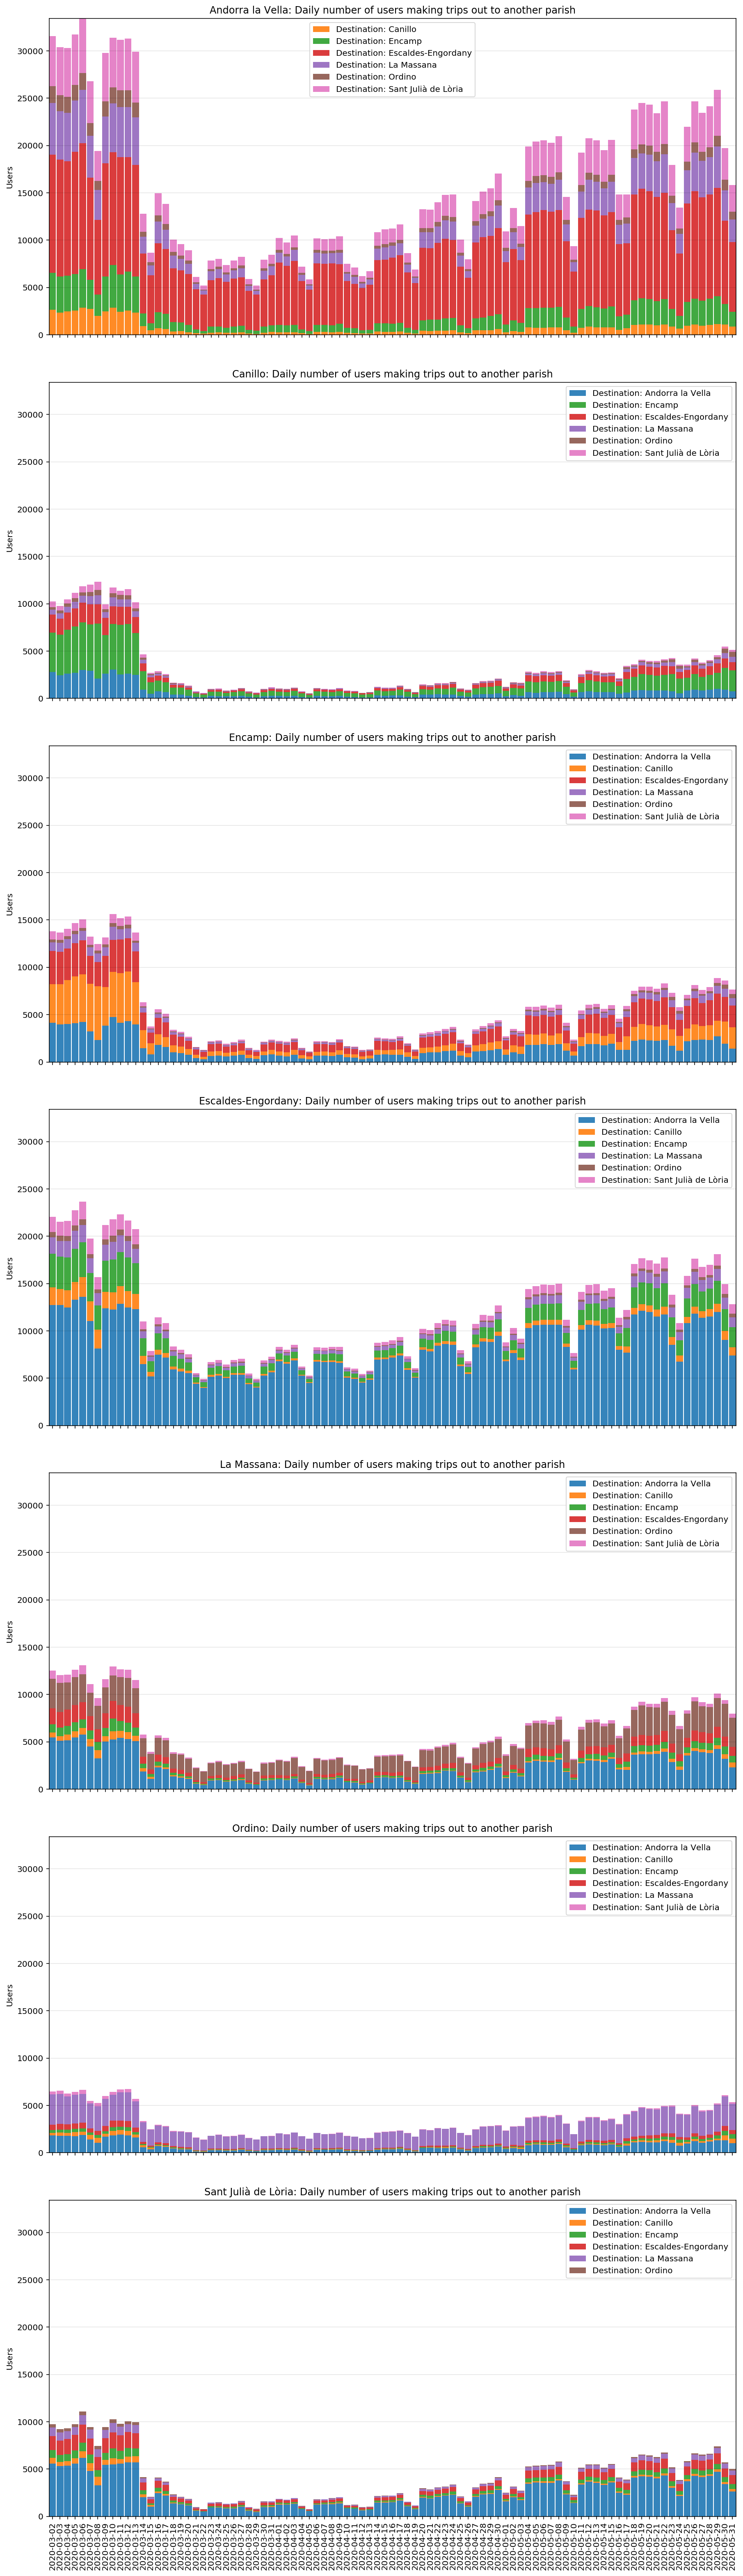

In [136]:
"""
Make plots for  each parish
"""
COLOR='black'
set_colors(COLOR)

nrows=len(parishes)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, nrows*8),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.15)

for i, o_parish in enumerate(parishes):
    ax = axes.flat[i]
    bottom = None
    p_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[ORIGIN_PARISH]==o_parish]
    for d_parish in parishes:
        if o_parish == d_parish:
            continue
        od_p_df = p_df[p_df[DESTINATION_PARISH]==d_parish]
        index = od_p_df[DATE].astype(str)
        users = od_p_df[USER_COUNT]
        ax.bar(index,
               users, 
               0.9, 
               color=parish_colors[d_parish],
               label='Destination: %s'%d_parish,
               alpha=0.9,
               bottom=bottom,
              )
        if bottom is  None:
            bottom = np.array(users)
        else:
            bottom += np.array(users)
    ax.set_ylabel('Users')
    ax.set_title('%s: Daily number of users making trips out to another parish' % o_parish)
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.legend()
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

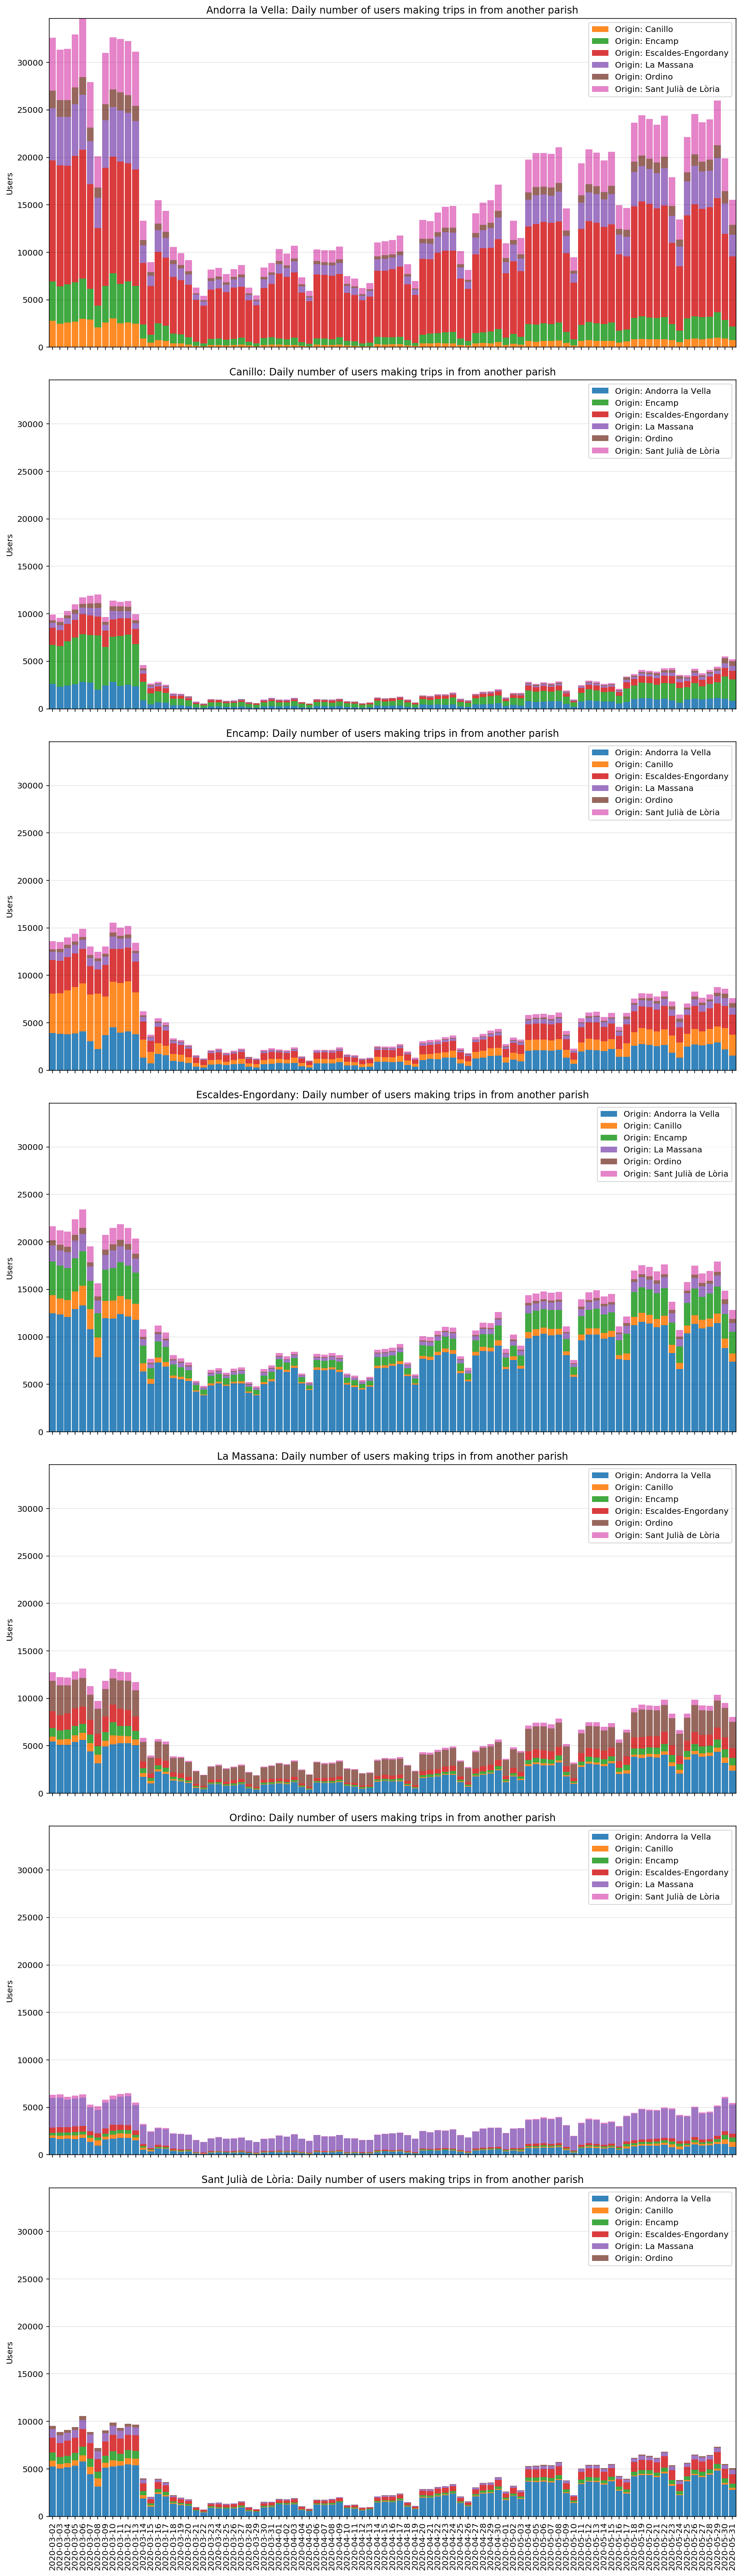

In [86]:
"""
Make plots for  each parish
"""
nrows=len(parishes)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, nrows*8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1)

for i, d_parish in enumerate(parishes):
    ax = axes.flat[i]
    bottom = None
    p_df = trips_between_parishes_2020_df[trips_between_parishes_2020_df[DESTINATION_PARISH]==d_parish]
    for o_parish in parishes:
        if o_parish == d_parish:
            continue
        od_p_df = p_df[p_df[ORIGIN_PARISH]==o_parish]
        index = od_p_df[DATE].astype(str)
        users = od_p_df[USER_COUNT]
        ax.bar(index,
               users, 
               0.9, 
               color=parish_colors[o_parish],
               label='Origin: %s'%o_parish,
               alpha=0.9,
               bottom=bottom,
              )
        if bottom is  None:
            bottom = np.array(users)
        else:
            bottom += np.array(users)
    ax.set_ylabel('Users')
    ax.set_title('%s: Daily number of users making trips in from another parish' % d_parish)
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.get_figure().set_facecolor('w')
    ax.legend()#bbox_to_anchor=(1.24, 1), loc='upper right', ncol=1)
    ax.tick_params(axis='x', labelrotation=90)

plt.show()